## Import package and setting

In [1]:
import pandas as pd
import seaborn as sns
#from pymer4.models import Lmer
from datetime import timedelta
import matplotlib.pyplot as plt
#from skimpy import skim


import matplotlib as mpl
from matplotlib.font_manager import fontManager

# 改style要在改font之前
# plt.style.use('seaborn')  

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%load_ext rpy2.ipython

c:\Users\chankalong\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
%%R
library(jtools)
library(tidyverse)
library(ggplot2)
library(emmeans)
library(easystats)
library(broom.mixed)
library(ggpubr)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.0     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.1     v tibble    3.1.8
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.1     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: # Attaching packages: easystats 0.6.0 (red = needs update)
x bayestestR  0.13.0   x correlation 0.8.3 
x datawizard  0.6.5    v effectsize  0.8.3 
x insight     0.19.0   v modelbased  0.8.6 
x performance 0.10.2   x parameters  0.20.2
x report      0.5.6    x see         0.7.4 

Restart the R-Session and update packages in red with `easystats::easystats_update()`.


R[write to console]: Registered S3 methods overwritten by 'broom':
  method            from  
  tidy.glht         jtools
  tidy.summary.glht jtools



## Import data and clean

In [3]:
sst_data = pd.read_excel('combine_clean_sst.xlsx')
sst_data['year_month'] = sst_data['application_date'].dt.strftime('%Y-%m')
gender_choice = list(sst_data['gender'].unique())
edu_choice = list(sst_data['edu'].unique())
edu_choice.pop(1)
timepoint_choice = list(sst_data['timepoint'].unique())
sst_data_r = sst_data.drop(columns=['close_case_problem', 'Column35', 'Column36'])

crosstab = pd.crosstab(sst_data_r['email'], sst_data_r['timepoint'], margins=True)
completed_email = crosstab[crosstab['All'] == 3].reset_index()['email']
sst_data_r_completed = sst_data_r[sst_data_r['email'].isin(completed_email)]

nan

## Demographic

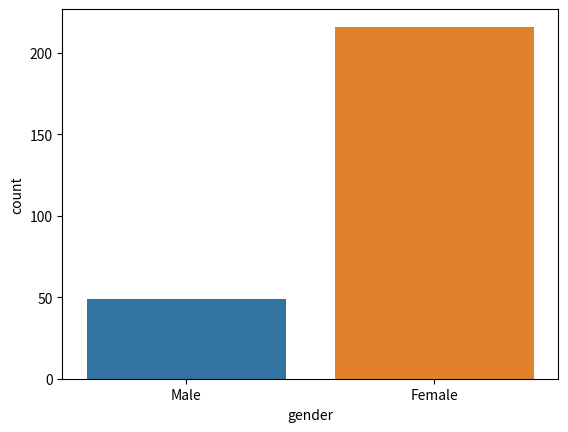

In [4]:
sns.countplot(x = 'gender', data = sst_data_r);

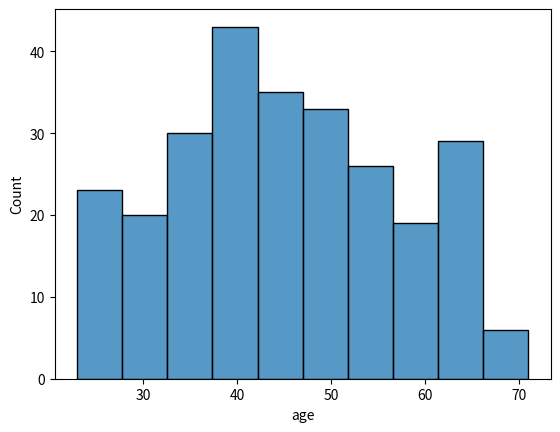

In [5]:
sns.histplot(x = 'age', data = sst_data_r);

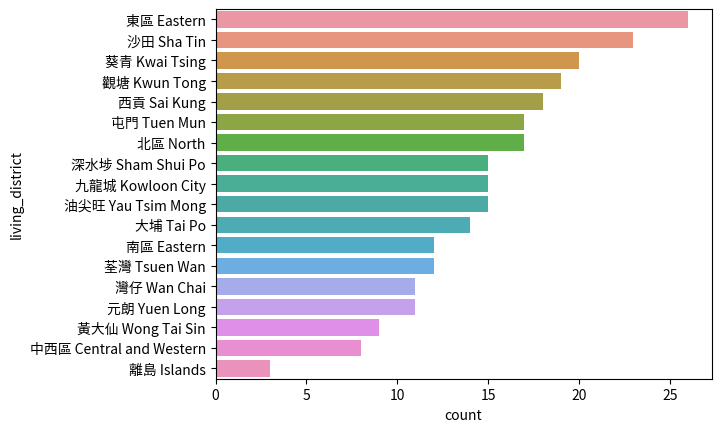

In [6]:
sns.countplot(y = 'living_district', data = sst_data_r, order = sst_data_r['living_district'].value_counts().index);

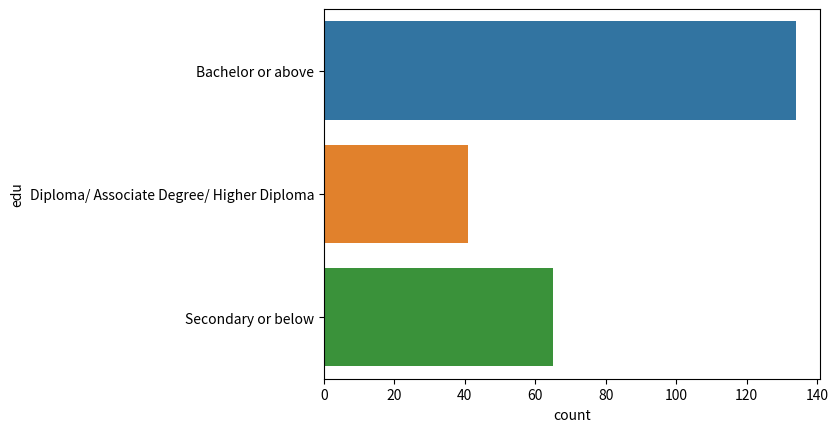

In [7]:
sns.countplot(y = 'edu', data = sst_data_r);
#plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

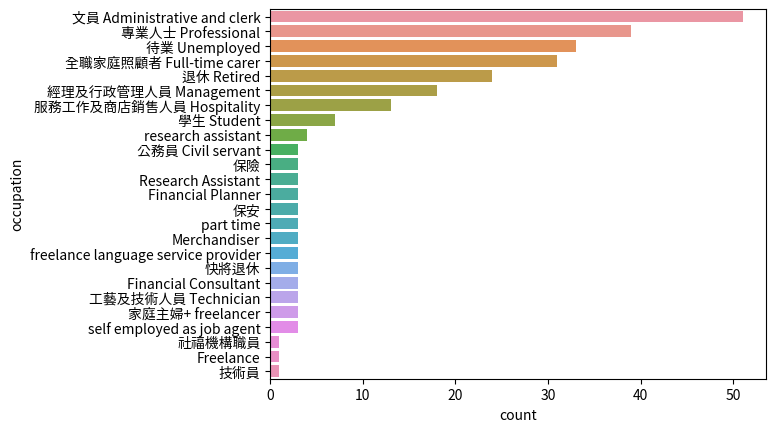

In [8]:
sns.countplot(y = 'occupation', data = sst_data_r, order = sst_data_r['occupation'].value_counts().index);

### Number of day from application to enquiry to service

In [9]:
print("application to service: " + str(timedelta(days=sst_data_r['service_application'].mean().round())))
print("enquiry to service: " + str(timedelta(days=sst_data_r['service_enquiry'].mean().round())))
print("application to enquiry: " + str(timedelta(days=sst_data_r['enquiry_application'].mean().round())))

application to service: 25 days, 0:00:00
enquiry to service: 19 days, 0:00:00
application to enquiry: 7 days, 0:00:00


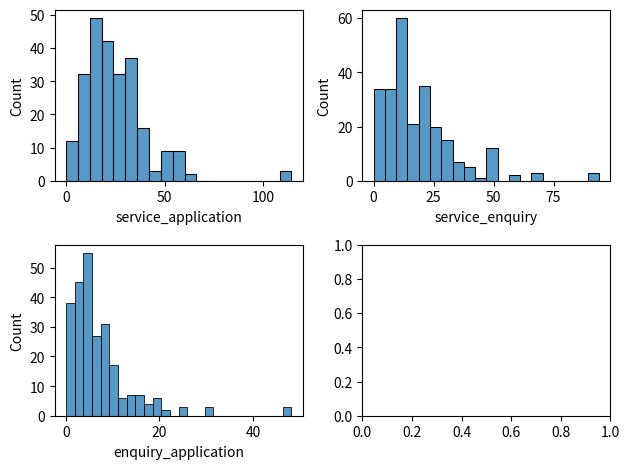

In [10]:
fig, ax = plt.subplots(2,2)
sns.histplot(x='service_application',data=sst_data_r, ax=ax[0,0]);
sns.histplot(x='service_enquiry',data=sst_data_r, ax=ax[0,1]);
sns.histplot(x='enquiry_application',data=sst_data_r, ax=ax[1,0]);
plt.tight_layout();

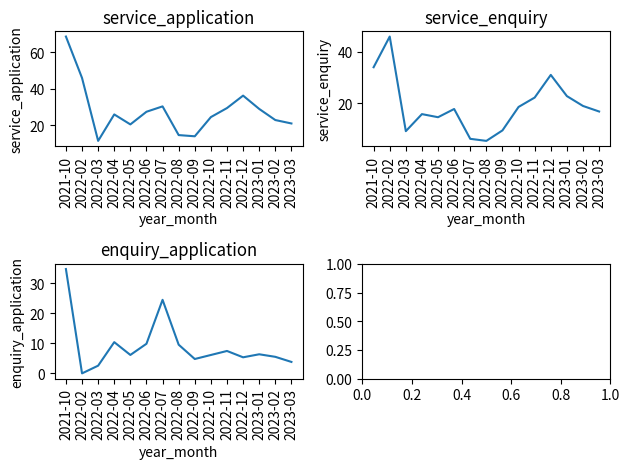

In [11]:
sst_data_r_plot = sst_data_r[sst_data_r['timepoint'] == '1st'].sort_values('year_month')
fig, ax = plt.subplots(2,2)

plot1 = sns.lineplot(x='year_month',y='service_application',data=sst_data_r_plot, ci=None, ax=ax[0,0])
plot1.set(title='service_application')
plot1.tick_params(axis='x', rotation=90)

plot2 = sns.lineplot(x='year_month',y='service_enquiry',data=sst_data_r_plot, ci=None, ax=ax[0,1])
plot2.set(title='service_enquiry')
plot2.tick_params(axis='x', rotation=90)

plot3 = sns.lineplot(x='year_month',y='enquiry_application',data=sst_data_r_plot, ci=None, ax=ax[1,0])
plot3.set(title='enquiry_application')
plot3.tick_params(axis='x', rotation=90)

plt.tight_layout();

## Analysis only include timepoint

In [12]:
%%R -i sst_data_r -o model_goal_all_result -o model_dominated_all_result -o model_confidence_all_result -i sst_data_r_completed -o model_goal_completed_result -o model_dominated_completed_result -o model_confidence_completed_result

# All
model_goal_all = lmerTest::lmer("goal_oriented ~ 1 + timepoint + (1 | email)", data=sst_data_r)
model_dominated_all = lmerTest::lmer("dominated ~ 1 + timepoint + (1 | email)", data=sst_data_r)
model_confidence_all = lmerTest::lmer("confidence ~ 1 + timepoint + (1 | email)", data=sst_data_r)

model_goal_all_result = summ(model_goal_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_all_result = summ(model_dominated_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_all_result = summ(model_confidence_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

# Completed
model_goal_completed = lmerTest::lmer("goal_oriented ~ 1 + timepoint + (1 | email)", data=sst_data_r_completed)
model_dominated_completed = lmerTest::lmer("dominated ~ 1 + timepoint + (1 | email)", data=sst_data_r_completed)
model_confidence_completed = lmerTest::lmer("confidence ~ 1 + timepoint + (1 | email)", data=sst_data_r_completed)

model_goal_completed_result = summ(model_goal_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_completed_result = summ(model_dominated_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_completed_result = summ(model_confidence_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

In [13]:
model_goal_result = pd.concat([model_goal_all_result, model_goal_completed_result], axis=1)
model_goal_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_dominated_result = pd.concat([model_dominated_all_result, model_dominated_completed_result], axis=1)
model_dominated_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_confidence_result = pd.concat([model_confidence_all_result, model_confidence_completed_result], axis=1)
model_confidence_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

print('Model of goal_oriented')
model_goal_result
print('Model of dominated')
model_dominated_result
print('Model of confidence')
model_confidence_result

Model of goal_oriented


All case              Completed case             
                 Est.  t val.    p           Est.  t val.    p
(Intercept)     3.983  22.264  0.0          4.365  18.045  0.0
timepoint2nd    3.247  11.556  0.0          3.032   9.132  0.0
timepoint3rd    2.676   8.794  0.0          2.302   6.932  0.0

Model of dominated


All case              Completed case             
                 Est.  t val.    p           Est.  t val.    p
(Intercept)     6.986  39.826  0.0          6.937  28.373  0.0
timepoint2nd   -1.419  -5.471  0.0         -1.556  -4.931  0.0
timepoint3rd   -2.448  -8.657  0.0         -2.429  -7.699  0.0

Model of confidence


All case              Completed case             
                 Est.  t val.    p           Est.  t val.    p
(Intercept)     4.133  26.392  0.0          4.492  21.405  0.0
timepoint2nd    2.742  13.056  0.0          2.571  10.284  0.0
timepoint3rd    2.655  11.541  0.0          2.429   9.713  0.0

## Analysis include covariate
- number of session
- DASS
- age
- gender
- edu

### Influence of number of session

In [14]:
%%R -i sst_data_r -o model_goal_session_all_result -o model_dominated_session_all_result -o model_confidence_session_all_result -i sst_data_r_completed -o model_goal_session_completed_result -o model_dominated_session_completed_result -o model_confidence_session_completed_result

# All
model_goal_session_all = lmerTest::lmer("goal_oriented ~ 1 + timepoint + session_number + timepoint * session_number + (1 | email)", data=sst_data_r)
model_dominated_session_all = lmerTest::lmer("dominated ~ 1 + timepoint + session_number + timepoint * session_number + (1 | email)", data=sst_data_r)
model_confidence_session_all = lmerTest::lmer("confidence ~ 1 + timepoint + session_number + timepoint * session_number + (1 | email)", data=sst_data_r)

model_goal_session_all_result = summ(model_goal_session_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_session_all_result = summ(model_dominated_session_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_session_all_result = summ(model_confidence_session_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

# Completed
model_goal_session_completed = lmerTest::lmer("goal_oriented ~ 1 + timepoint + session_number + timepoint * session_number + (1 | email)", data=sst_data_r_completed)
model_dominated_session_completed = lmerTest::lmer("dominated ~ 1 + timepoint + session_number + timepoint * session_number + (1 | email)", data=sst_data_r_completed)
model_confidence_session_completed = lmerTest::lmer("confidence ~ 1 + timepoint + session_number + timepoint * session_number + (1 | email)", data=sst_data_r_completed)

model_goal_session_completed_result = summ(model_goal_session_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_session_completed_result = summ(model_dominated_session_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_session_completed_result = summ(model_confidence_session_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

In [15]:
model_goal_session_result = pd.concat([model_goal_session_all_result, model_goal_session_completed_result], axis=1)
model_goal_session_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_dominated_session_result = pd.concat([model_dominated_session_all_result, model_dominated_session_completed_result], axis=1)
model_dominated_session_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_confidence_session_result = pd.concat([model_confidence_session_all_result, model_confidence_session_completed_result], axis=1)
model_confidence_session_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

print('Model of goal_oriented')
model_goal_session_result
print('Model of dominated')
model_dominated_session_result
print('Model of confidence')
model_confidence_session_result

Model of goal_oriented


All case               Completed case         \
                                Est. t val.      p           Est. t val.   
(Intercept)                    3.649  5.079  0.000          4.074  4.105   
timepoint2nd                   2.103  1.865  0.064          2.155  1.580   
timepoint3rd                   3.075  2.460  0.015          2.650  1.943   
session_number                 0.198  1.093  0.276          0.066  0.275   
timepoint2nd:session_number    0.185  0.662  0.509          0.226  0.688   
timepoint3rd:session_number   -0.217 -0.712  0.478         -0.085 -0.260   

                                    
                                 p  
(Intercept)                  0.000  
timepoint2nd                 0.117  
timepoint3rd                 0.054  
session_number               0.784  
timepoint2nd:session_number  0.493  
timepoint3rd:session_number  0.795

Model of dominated


All case                Completed case         \
                                Est.  t val.      p           Est. t val.   
(Intercept)                    7.674  10.917  0.000          7.478  7.445   
timepoint2nd                  -2.164  -2.090  0.038         -2.875 -2.229   
timepoint3rd                  -3.428  -2.961  0.004         -3.370 -2.612   
session_number                -0.201  -1.136  0.258         -0.135 -0.558   
timepoint2nd:session_number    0.189   0.737  0.463          0.321  1.036   
timepoint3rd:session_number    0.273   0.969  0.334          0.240  0.773   

                                    
                                 p  
(Intercept)                  0.000  
timepoint2nd                 0.028  
timepoint3rd                 0.010  
session_number               0.578  
timepoint2nd:session_number  0.303  
timepoint3rd:session_number  0.441

Model of confidence


All case               Completed case         \
                                Est. t val.      p           Est. t val.   
(Intercept)                    3.681  6.158  0.000          5.093  5.942   
timepoint2nd                   1.590  1.957  0.052          0.982  0.965   
timepoint3rd                   1.614  1.765  0.080          0.697  0.685   
session_number                 0.171  1.138  0.257         -0.151 -0.734   
timepoint2nd:session_number    0.252  1.252  0.213          0.392  1.604   
timepoint3rd:session_number    0.217  0.979  0.329          0.427  1.747   

                                    
                                 p  
(Intercept)                  0.000  
timepoint2nd                 0.336  
timepoint3rd                 0.495  
session_number               0.464  
timepoint2nd:session_number  0.111  
timepoint3rd:session_number  0.083

### Influence of DASS-D

In [16]:
%%R -i sst_data_r -o model_goal_dass_d_all_result -o model_dominated_dass_d_all_result -o model_confidence_dass_d_all_result -i sst_data_r_completed -o model_goal_dass_d_completed_result -o model_dominated_dass_d_completed_result -o model_confidence_dass_d_completed_result

# All
model_goal_dass_d_all = lmerTest::lmer("goal_oriented ~ 1 + timepoint + dass_d + timepoint * dass_d + (1 | email)", data=sst_data_r)
model_dominated_dass_d_all = lmerTest::lmer("dominated ~ 1 + timepoint + dass_d + timepoint * dass_d + (1 | email)", data=sst_data_r)
model_confidence_dass_d_all = lmerTest::lmer("confidence ~ 1 + timepoint + dass_d + timepoint * dass_d + (1 | email)", data=sst_data_r)

model_goal_dass_d_all_result = summ(model_goal_dass_d_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_dass_d_all_result = summ(model_dominated_dass_d_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_dass_d_all_result = summ(model_confidence_dass_d_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

# Completed
model_goal_dass_d_completed = lmerTest::lmer("goal_oriented ~ 1 + timepoint + dass_d + timepoint * dass_d + (1 | email)", data=sst_data_r_completed)
model_dominated_dass_d_completed = lmerTest::lmer("dominated ~ 1 + timepoint + dass_d + timepoint * dass_d + (1 | email)", data=sst_data_r_completed)
model_confidence_dass_d_completed = lmerTest::lmer("confidence ~ 1 + timepoint + dass_d + timepoint * dass_d + (1 | email)", data=sst_data_r_completed)

model_goal_dass_d_completed_result = summ(model_goal_dass_d_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_dass_d_completed_result = summ(model_dominated_dass_d_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_dass_d_completed_result = summ(model_confidence_dass_d_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

In [17]:
model_goal_dass_d_result = pd.concat([model_goal_dass_d_all_result, model_goal_dass_d_completed_result], axis=1)
model_goal_dass_d_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_dominated_dass_d_result = pd.concat([model_dominated_dass_d_all_result, model_dominated_dass_d_completed_result], axis=1)
model_dominated_dass_d_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_confidence_dass_d_result = pd.concat([model_confidence_dass_d_all_result, model_confidence_dass_d_completed_result], axis=1)
model_confidence_dass_d_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

print('Model of goal_oriented')
model_goal_dass_d_result
print('Model of dominated')
model_dominated_dass_d_result
print('Model of confidence')
model_confidence_dass_d_result

Model of goal_oriented


All case                Completed case               
                        Est.  t val.      p           Est.  t val.      p
(Intercept)            5.019  16.027  0.000          5.311  12.816  0.000
timepoint2nd           2.027   4.195  0.000          1.935   3.390  0.001
timepoint3rd           1.700   3.246  0.001          1.411   2.473  0.015
dass_d                -0.066  -4.026  0.000         -0.066  -2.732  0.007
timepoint2nd:dass_d    0.079   3.030  0.003          0.078   2.338  0.021
timepoint3rd:dass_d    0.059   1.988  0.048          0.059   1.769  0.079

Model of dominated


All case                Completed case               
                        Est.  t val.      p           Est.  t val.      p
(Intercept)            6.325  20.851  0.000          6.223  15.116  0.000
timepoint2nd          -1.634  -3.686  0.000         -1.775  -3.307  0.001
timepoint3rd          -1.762  -3.644  0.000         -1.699  -3.165  0.002
dass_d                 0.046   2.906  0.004          0.056   2.328  0.021
timepoint2nd:dass_d    0.012   0.516  0.607          0.010   0.311  0.756
timepoint3rd:dass_d   -0.045  -1.622  0.107         -0.053  -1.672  0.097

Model of confidence


All case                Completed case               
                        Est.  t val.      p           Est.  t val.      p
(Intercept)            4.924  18.776  0.000          5.314  15.155  0.000
timepoint2nd           2.211   6.232  0.000          1.921   4.494  0.000
timepoint3rd           1.983   5.098  0.000          1.697   3.971  0.000
dass_d                -0.056  -4.074  0.000         -0.063  -3.065  0.003
timepoint2nd:dass_d    0.040   2.080  0.039          0.052   2.075  0.040
timepoint3rd:dass_d    0.050   2.240  0.026          0.056   2.248  0.026

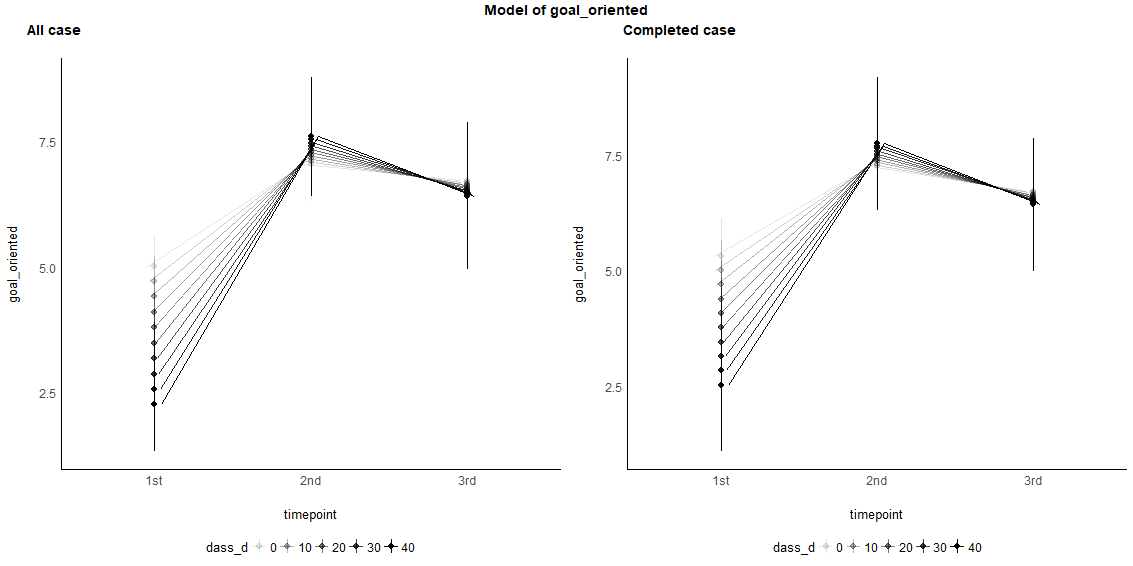

In [18]:
%%R -i sst_data_r -i sst_data_r_completed -w 40 -h 20 --units cm
plt_model_goal_dass_d_all <- plot(estimate_means(model_goal_dass_d_all, at = c("timepoint", "dass_d"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_goal_dass_d_all$layers[[1]] <- NULL
#plt_model_goal_dass_d_all

plt_model_goal_dass_d_completed <- plot(estimate_means(model_goal_dass_d_completed, at = c("timepoint", "dass_d"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_goal_dass_d_completed$layers[[1]] <- NULL
#plt_model_goal_dass_d_completed

ggarrange(plt_model_goal_dass_d_all, plt_model_goal_dass_d_completed,
                    labels = c("All case", "Completed case"),
                    ncol = 2, nrow = 1) %>% annotate_figure(top = text_grob("Model of goal_oriented", face = "bold", size = 14))

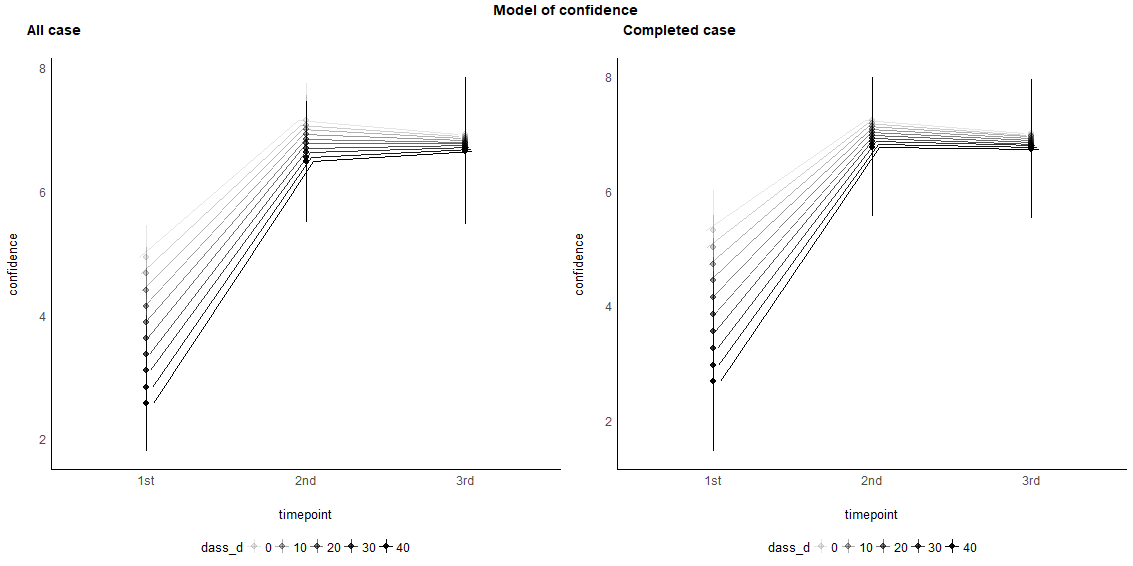

In [19]:
%%R -i sst_data_r -i sst_data_r_completed -w 40 -h 20 --units cm
plt_model_confidence_dass_d_all <- plot(estimate_means(model_confidence_dass_d_all, at = c("timepoint", "dass_d"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_confidence_dass_d_all$layers[[1]] <- NULL
#plt_model_goal_dass_d_all

plt_model_confidence_dass_d_completed <- plot(estimate_means(model_confidence_dass_d_completed, at = c("timepoint", "dass_d"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_confidence_dass_d_completed$layers[[1]] <- NULL
#plt_model_goal_dass_d_completed

ggarrange(plt_model_confidence_dass_d_all, plt_model_confidence_dass_d_completed,
                    labels = c("All case", "Completed case"),
                    ncol = 2, nrow = 1) %>% annotate_figure(top = text_grob("Model of confidence", face = "bold", size = 14))

### Influence of DASS-D Clinical

In [20]:
%%R -i sst_data_r -o model_goal_dass_d_yes_all_result -o model_dominated_dass_d_yes_all_result -o model_confidence_dass_d_yes_all_result -i sst_data_r_completed -o model_goal_dass_d_yes_completed_result -o model_dominated_dass_d_yes_completed_result -o model_confidence_dass_d_yes_completed_result

# All
model_goal_dass_d_yes_all = lmerTest::lmer("goal_oriented ~ 1 + timepoint + depression_moderate_above + timepoint * depression_moderate_above + (1 | email)", data=sst_data_r)
model_dominated_dass_d_yes_all = lmerTest::lmer("dominated ~ 1 + timepoint + depression_moderate_above + timepoint * depression_moderate_above + (1 | email)", data=sst_data_r)
model_confidence_dass_d_yes_all = lmerTest::lmer("confidence ~ 1 + timepoint + depression_moderate_above + timepoint * depression_moderate_above + (1 | email)", data=sst_data_r)

model_goal_dass_d_yes_all_result = summ(model_goal_dass_d_yes_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_dass_d_yes_all_result = summ(model_dominated_dass_d_yes_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_dass_d_yes_all_result = summ(model_confidence_dass_d_yes_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

# Completed
model_goal_dass_d_yes_completed = lmerTest::lmer("goal_oriented ~ 1 + timepoint + depression_moderate_above + timepoint * depression_moderate_above + (1 | email)", data=sst_data_r_completed)
model_dominated_dass_d_yes_completed = lmerTest::lmer("dominated ~ 1 + timepoint + depression_moderate_above + timepoint * depression_moderate_above + (1 | email)", data=sst_data_r_completed)
model_confidence_dass_d_yes_completed = lmerTest::lmer("confidence ~ 1 + timepoint + depression_moderate_above + timepoint * depression_moderate_above + (1 | email)", data=sst_data_r_completed)

model_goal_dass_d_yes_completed_result = summ(model_goal_dass_d_yes_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_dass_d_yes_completed_result = summ(model_dominated_dass_d_yes_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_dass_d_yes_completed_result = summ(model_confidence_dass_d_yes_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

In [21]:
model_goal_dass_d_yes_result = pd.concat([model_goal_dass_d_yes_all_result, model_goal_dass_d_yes_completed_result], axis=1)
model_goal_dass_d_yes_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_dominated_dass_d_yes_result = pd.concat([model_dominated_dass_d_yes_all_result, model_dominated_dass_d_yes_completed_result], axis=1)
model_dominated_dass_d_yes_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_confidence_dass_d_yes_result = pd.concat([model_confidence_dass_d_yes_all_result, model_confidence_dass_d_yes_completed_result], axis=1)
model_confidence_dass_d_yes_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

print('Model of goal_oriented')
model_goal_dass_d_yes_result
print('Model of dominated')
model_dominated_dass_d_yes_result
print('Model of confidence')
model_confidence_dass_d_yes_result

Model of goal_oriented


All case                 \
                                              Est.  t val.      p   
(Intercept)                                  4.537  17.014  0.000   
timepoint2nd                                 2.718   6.611  0.000   
timepoint3rd                                 2.006   4.641  0.000   
depression_moderate_aboveYes                -1.046  -2.833  0.005   
timepoint2nd:depression_moderate_aboveYes    1.015   1.768  0.079   
timepoint3rd:depression_moderate_aboveYes    1.215   1.948  0.053   

                                          Completed case                 
                                                    Est.  t val.      p  
(Intercept)                                        4.909  14.783  0.000  
timepoint2nd                                       2.515   5.499  0.000  
timepoint3rd                                       1.636   3.578  0.001  
depression_moderate_aboveYes                      -1.123  -2.292  0.023  
timepoint2nd:depression_moderate_aboveYes          1.092   1.617  0.108  
timepoint3rd:depression_moderate_aboveYes          1.292   1.914  0.058

Model of dominated


All case                 \
                                              Est.  t val.      p   
(Intercept)                                  6.537  25.458  0.000   
timepoint2nd                                -1.391  -3.701  0.000   
timepoint3rd                                -2.076  -5.232  0.000   
depression_moderate_aboveYes                 0.971   2.734  0.007   
timepoint2nd:depression_moderate_aboveYes   -0.170  -0.323  0.747   
timepoint3rd:depression_moderate_aboveYes   -0.695  -1.212  0.227   

                                          Completed case                 
                                                    Est.  t val.      p  
(Intercept)                                        6.333  19.283  0.000  
timepoint2nd                                      -1.333  -3.104  0.002  
timepoint3rd                                      -1.909  -4.444  0.000  
depression_moderate_aboveYes                       1.452   2.996  0.003  
timepoint2nd:depression_moderate_aboveYes         -0.667  -1.051  0.295  
timepoint3rd:depression_moderate_aboveYes         -1.127  -1.777  0.078

Model of confidence


All case                 \
                                              Est.  t val.      p   
(Intercept)                                  4.556  20.420  0.000   
timepoint2nd                                 2.380   7.993  0.000   
timepoint3rd                                 2.210   7.004  0.000   
depression_moderate_aboveYes                -0.962  -3.117  0.002   
timepoint2nd:depression_moderate_aboveYes    0.872   2.092  0.038   
timepoint3rd:depression_moderate_aboveYes    1.044   2.280  0.024   

                                          Completed case                 
                                                    Est.  t val.      p  
(Intercept)                                        4.879  17.267  0.000  
timepoint2nd                                       2.242   6.555  0.000  
timepoint3rd                                       2.000   5.846  0.000  
depression_moderate_aboveYes                      -0.950  -2.278  0.024  
timepoint2nd:depression_moderate_aboveYes          0.865   1.712  0.089  
timepoint3rd:depression_moderate_aboveYes          1.036   2.051  0.042

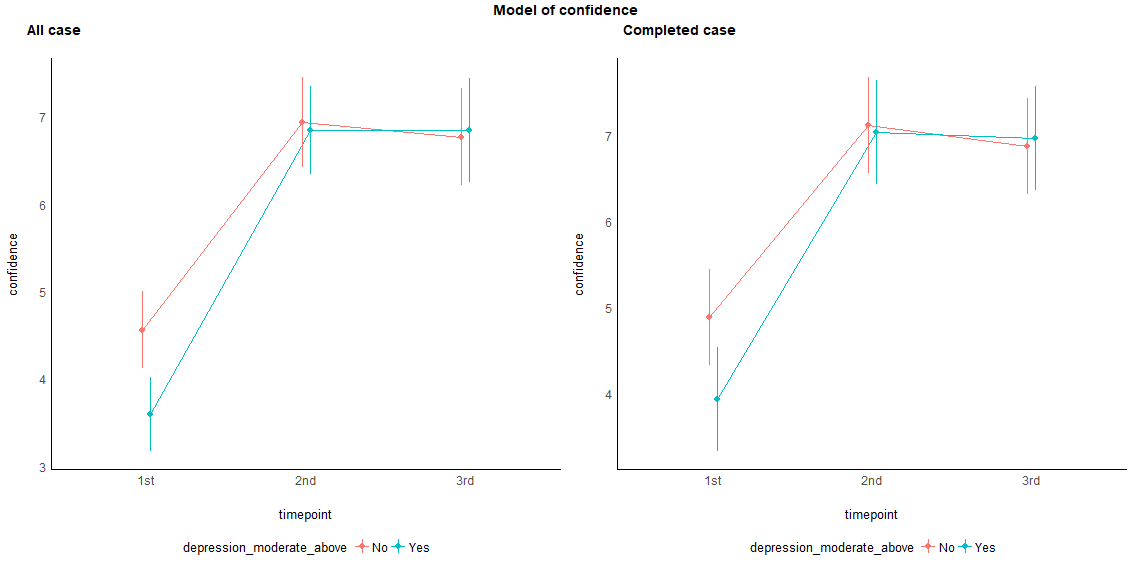

In [22]:
%%R -i sst_data_r -i sst_data_r_completed -w 40 -h 20 --units cm
plt_model_confidence_dass_d_yes_all <- plot(estimate_means(model_confidence_dass_d_yes_all, at = c("timepoint", "depression_moderate_above"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_confidence_dass_d_yes_all$layers[[1]] <- NULL
#plt_model_goal_dass_d_all

plt_model_confidence_dass_d_yes_completed <- plot(estimate_means(model_confidence_dass_d_yes_completed, at = c("timepoint", "depression_moderate_above"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_confidence_dass_d_yes_completed$layers[[1]] <- NULL
#plt_model_goal_dass_d_completed

ggarrange(plt_model_confidence_dass_d_yes_all, plt_model_confidence_dass_d_yes_completed,
                    labels = c("All case", "Completed case"),
                    ncol = 2, nrow = 1) %>% annotate_figure(top = text_grob("Model of confidence", face = "bold", size = 14))

### Influence of DASS-A

In [23]:
%%R -i sst_data_r -o model_goal_dass_a_all_result -o model_dominated_dass_a_all_result -o model_confidence_dass_a_all_result -i sst_data_r_completed -o model_goal_dass_a_completed_result -o model_dominated_dass_a_completed_result -o model_confidence_dass_a_completed_result

# All
model_goal_dass_a_all = lmerTest::lmer("goal_oriented ~ 1 + timepoint + dass_a + timepoint * dass_a + (1 | email)", data=sst_data_r)
model_dominated_dass_a_all = lmerTest::lmer("dominated ~ 1 + timepoint + dass_a + timepoint * dass_a + (1 | email)", data=sst_data_r)
model_confidence_dass_a_all = lmerTest::lmer("confidence ~ 1 + timepoint + dass_a + timepoint * dass_a + (1 | email)", data=sst_data_r)

model_goal_dass_a_all_result = summ(model_goal_dass_a_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_dass_a_all_result = summ(model_dominated_dass_a_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_dass_a_all_result = summ(model_confidence_dass_a_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

# Completed
model_goal_dass_a_completed = lmerTest::lmer("goal_oriented ~ 1 + timepoint + dass_a + timepoint * dass_a + (1 | email)", data=sst_data_r_completed)
model_dominated_dass_a_completed = lmerTest::lmer("dominated ~ 1 + timepoint + dass_a + timepoint * dass_a + (1 | email)", data=sst_data_r_completed)
model_confidence_dass_a_completed = lmerTest::lmer("confidence ~ 1 + timepoint + dass_a + timepoint * dass_a + (1 | email)", data=sst_data_r_completed)

model_goal_dass_a_completed_result = summ(model_goal_dass_a_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_dass_a_completed_result = summ(model_dominated_dass_a_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_dass_a_completed_result = summ(model_confidence_dass_a_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

R[write to console]: boundary (singular) fit: see help('isSingular')



In [24]:
model_goal_dass_a_result = pd.concat([model_goal_dass_a_all_result, model_goal_dass_a_completed_result], axis=1)
model_goal_dass_a_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_dominated_dass_a_result = pd.concat([model_dominated_dass_a_all_result, model_dominated_dass_a_completed_result], axis=1)
model_dominated_dass_a_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_confidence_dass_a_result = pd.concat([model_confidence_dass_a_all_result, model_confidence_dass_a_completed_result], axis=1)
model_confidence_dass_a_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

print('Model of goal_oriented')
model_goal_dass_a_result
print('Model of dominated')
model_dominated_dass_a_result
print('Model of confidence')
model_confidence_dass_a_result

Model of goal_oriented


All case                Completed case               
                        Est.  t val.      p           Est.  t val.      p
(Intercept)            4.932  14.746  0.000          5.226  11.494  0.000
timepoint2nd           2.134   4.043  0.000          2.124   3.366  0.001
timepoint3rd           2.115   3.699  0.000          1.820   2.884  0.005
dass_a                -0.069  -3.358  0.001         -0.066  -2.170  0.031
timepoint2nd:dass_a    0.082   2.480  0.014          0.071   1.675  0.097
timepoint3rd:dass_a    0.035   0.943  0.347          0.032   0.769  0.444

Model of dominated


All case                Completed case               
                        Est.  t val.      p           Est.  t val.      p
(Intercept)            6.120  18.939  0.000          5.919  13.135  0.000
timepoint2nd          -1.095  -2.290  0.023         -1.286  -2.214  0.029
timepoint3rd          -1.330  -2.550  0.012         -1.205  -2.073  0.040
dass_a                 0.067   3.414  0.001          0.086   2.841  0.005
timepoint2nd:dass_a   -0.028  -0.934  0.352         -0.028  -0.719  0.473
timepoint3rd:dass_a   -0.083  -2.444  0.015         -0.097  -2.491  0.014

Model of confidence


All case                Completed case               
                        Est.  t val.      p           Est.  t val.      p
(Intercept)            4.930  17.650  0.000          5.121  13.241  0.000
timepoint2nd           2.167   5.593  0.000          2.312   4.856  0.000
timepoint3rd           2.118   4.993  0.000          2.038   4.281  0.000
dass_a                -0.064  -3.748  0.000         -0.054  -2.078  0.039
timepoint2nd:dass_a    0.049   2.017  0.045          0.026   0.814  0.417
timepoint3rd:dass_a    0.045   1.634  0.104          0.035   1.088  0.279

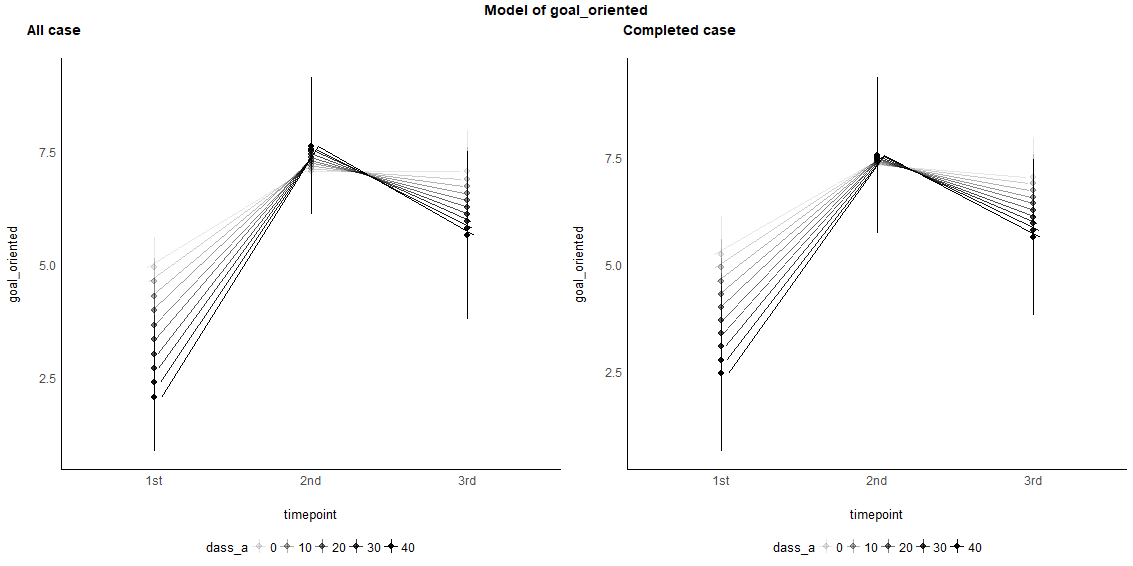

In [25]:
%%R -i sst_data_r -i sst_data_r_completed -w 40 -h 20 --units cm
plt_model_goal_dass_a_all <- plot(estimate_means(model_goal_dass_a_all, at = c("timepoint", "dass_a"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_goal_dass_a_all$layers[[1]] <- NULL
#plt_model_goal_dass_d_all

plt_model_goal_dass_a_completed <- plot(estimate_means(model_goal_dass_a_completed, at = c("timepoint", "dass_a"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_goal_dass_a_completed$layers[[1]] <- NULL
#plt_model_goal_dass_d_completed

ggarrange(plt_model_goal_dass_a_all, plt_model_goal_dass_a_completed,
                    labels = c("All case", "Completed case"),
                    ncol = 2, nrow = 1) %>% annotate_figure(top = text_grob("Model of goal_oriented", face = "bold", size = 14))

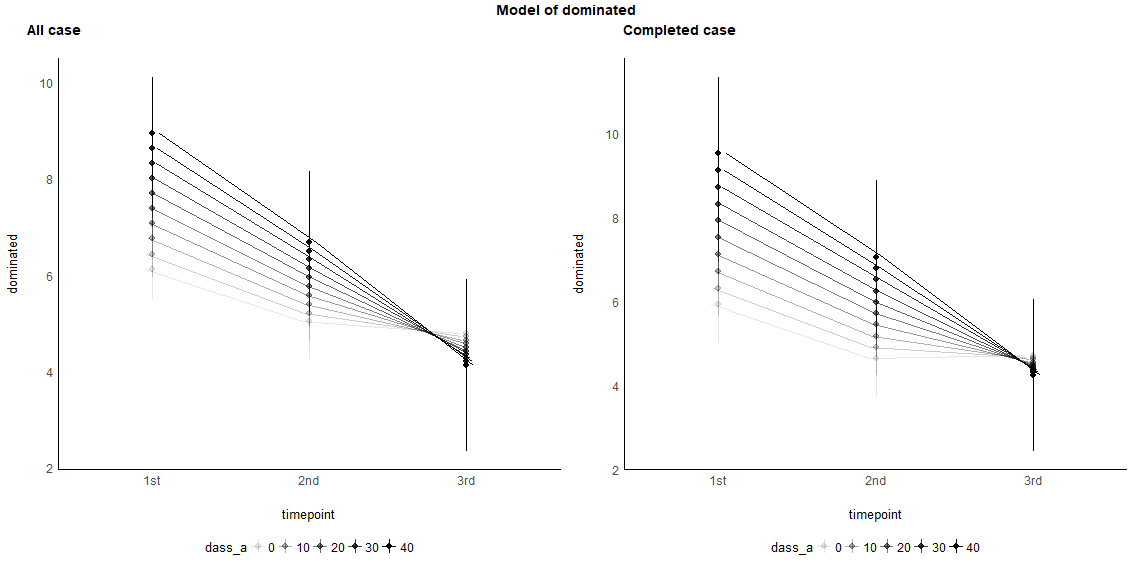

In [26]:
%%R -i sst_data_r -i sst_data_r_completed -w 40 -h 20 --units cm
plt_model_dominated_dass_a_all <- plot(estimate_means(model_dominated_dass_a_all, at = c("timepoint", "dass_a"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_dominated_dass_a_all$layers[[1]] <- NULL
#plt_model_goal_dass_d_all

plt_model_dominated_dass_a_completed <- plot(estimate_means(model_dominated_dass_a_completed, at = c("timepoint", "dass_a"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_dominated_dass_a_completed$layers[[1]] <- NULL
#plt_model_goal_dass_d_completed

ggarrange(plt_model_dominated_dass_a_all, plt_model_dominated_dass_a_completed,
                    labels = c("All case", "Completed case"),
                    ncol = 2, nrow = 1) %>% annotate_figure(top = text_grob("Model of dominated", face = "bold", size = 14))

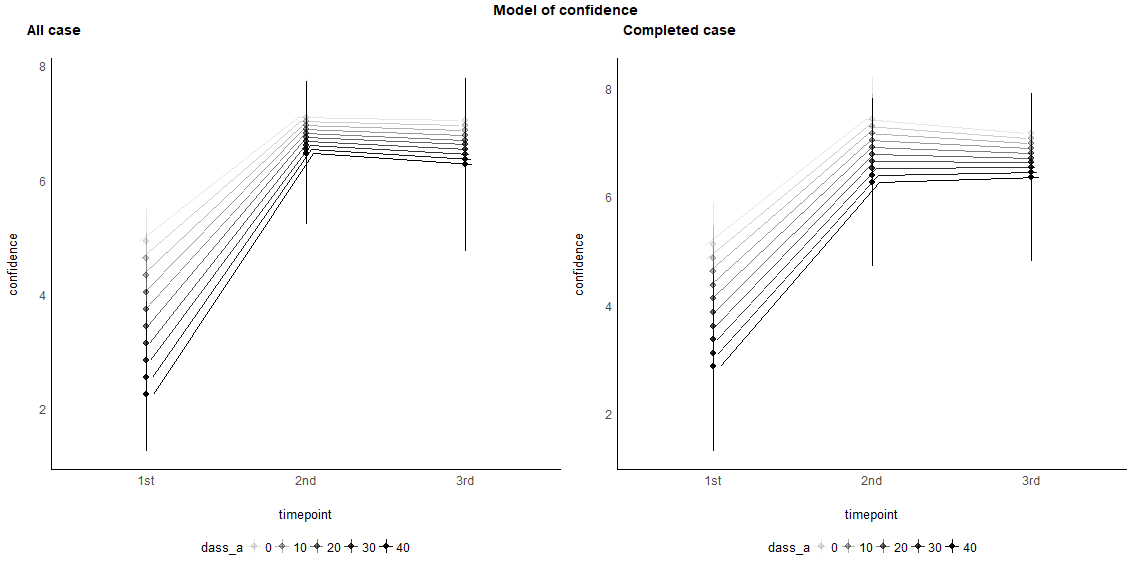

In [27]:
%%R -i sst_data_r -i sst_data_r_completed -w 40 -h 20 --units cm
plt_model_confidence_dass_a_all <- plot(estimate_means(model_confidence_dass_a_all, at = c("timepoint", "dass_a"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_confidence_dass_a_all$layers[[1]] <- NULL
#plt_model_goal_dass_d_all

plt_model_confidence_dass_a_completed <- plot(estimate_means(model_confidence_dass_a_completed, at = c("timepoint", "dass_a"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_confidence_dass_a_completed$layers[[1]] <- NULL
#plt_model_goal_dass_d_completed

ggarrange(plt_model_confidence_dass_a_all, plt_model_confidence_dass_a_completed,
                    labels = c("All case", "Completed case"),
                    ncol = 2, nrow = 1) %>% annotate_figure(top = text_grob("Model of confidence", face = "bold", size = 14))

### Influence of DASS-A Clinical

In [28]:
%%R -i sst_data_r -o model_goal_dass_a_yes_all_result -o model_dominated_dass_a_yes_all_result -o model_confidence_dass_a_yes_all_result -i sst_data_r_completed -o model_goal_dass_a_yes_completed_reslt -o model_dominated_dass_a_yes_completed_result -o model_confidence_dass_a_yes_completed_result

# All
model_goal_dass_a_yes_all = lmerTest::lmer("goal_oriented ~ 1 + timepoint + anxiety_moderate_above + timepoint * anxiety_moderate_above + (1 | email)", data=sst_data_r)
model_dominated_dass_a_yes_all = lmerTest::lmer("dominated ~ 1 + timepoint + anxiety_moderate_above + timepoint * anxiety_moderate_above + (1 | email)", data=sst_data_r)
model_confidence_dass_a_yes_all = lmerTest::lmer("confidence ~ 1 + timepoint + anxiety_moderate_above + timepoint * anxiety_moderate_above + (1 | email)", data=sst_data_r)

model_goal_dass_a_yes_all_result = summ(model_goal_dass_a_yes_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.) 
model_dominated_dass_a_yes_all_result = summ(model_dominated_dass_a_yes_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_dass_a_yes_all_result = summ(model_confidence_dass_a_yes_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

# Completed
model_goal_dass_a_yes_completed = lmerTest::lmer("goal_oriented ~ 1 + timepoint + anxiety_moderate_above + timepoint * anxiety_moderate_above + (1 | email)", data=sst_data_r_completed)
model_dominated_dass_a_yes_completed = lmerTest::lmer("dominated ~ 1 + timepoint + anxiety_moderate_above + timepoint * anxiety_moderate_above + (1 | email)", data=sst_data_r_completed)
model_confidence_dass_a_yes_completed = lmerTest::lmer("confidence ~ 1 + timepoint + anxiety_moderate_above + timepoint * anxiety_moderate_above + (1 | email)", data=sst_data_r_completed)

model_goal_dass_a_yes_completed_reslt = summ(model_goal_dass_a_yes_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_dass_a_yes_completed_result = summ(model_dominated_dass_a_yes_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_dass_a_yes_completed_result = summ(model_confidence_dass_a_yes_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

In [29]:
model_goal_dass_a_yes_result = pd.concat([model_goal_dass_a_yes_all_result, model_goal_dass_a_yes_completed_reslt], axis=1)
model_goal_dass_a_yes_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_dominated_dass_a_yes_result = pd.concat([model_dominated_dass_a_yes_all_result, model_dominated_dass_a_yes_completed_result], axis=1)
model_dominated_dass_a_yes_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_confidence_dass_a_yes_result = pd.concat([model_confidence_dass_a_yes_all_result, model_confidence_dass_a_yes_completed_result], axis=1)
model_confidence_dass_a_yes_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

print('Model of goal_oriented')
model_goal_dass_a_yes_result
print('Model of dominated')
model_dominated_dass_a_yes_result
print('Model of confidence')
model_confidence_dass_a_yes_result

Model of goal_oriented


All case                Completed case  \
                                           Est.  t val.      p           Est.   
(Intercept)                               4.526  14.244  0.000          4.800   
timepoint2nd                              2.394   4.817  0.000          2.300   
timepoint3rd                              2.720   5.040  0.000          2.450   
anxiety_moderate_aboveYes                -0.806  -2.067  0.040         -0.605   
timepoint2nd:anxiety_moderate_aboveYes    1.279   2.104  0.037          1.066   
timepoint3rd:anxiety_moderate_aboveYes   -0.128  -0.194  0.846         -0.328   

                                                       
                                        t val.      p  
(Intercept)                             11.252  0.000  
timepoint2nd                             3.913  0.000  
timepoint3rd                             4.168  0.000  
anxiety_moderate_aboveYes               -1.163  0.247  
timepoint2nd:anxiety_moderate_aboveYes   1.487  0.140  
timepoint3rd:anxiety_moderate_aboveYes  -0.458  0.648

Model of dominated


All case                Completed case  \
                                           Est.  t val.      p           Est.   
(Intercept)                               6.474  20.940  0.000          6.100   
timepoint2nd                             -1.056  -2.312  0.022         -0.850   
timepoint3rd                             -2.209  -4.426  0.000         -1.900   
anxiety_moderate_aboveYes                 0.860   2.265  0.024          1.339   
timepoint2nd:anxiety_moderate_aboveYes   -0.653  -1.168  0.244         -1.174   
timepoint3rd:anxiety_moderate_aboveYes   -0.356  -0.583  0.561         -0.783   

                                                       
                                        t val.      p  
(Intercept)                             14.298  0.000  
timepoint2nd                            -1.540  0.126  
timepoint3rd                            -3.442  0.001  
anxiety_moderate_aboveYes                2.573  0.011  
timepoint2nd:anxiety_moderate_aboveYes  -1.744  0.084  
timepoint3rd:anxiety_moderate_aboveYes  -1.163  0.247

Model of confidence


All case                Completed case  \
                                           Est.  t val.      p           Est.   
(Intercept)                               4.447  16.539  0.000          4.650   
timepoint2nd                              2.640   7.153  0.000          2.700   
timepoint3rd                              2.603   6.423  0.000          2.500   
anxiety_moderate_aboveYes                -0.594  -1.800  0.073         -0.309   
timepoint2nd:anxiety_moderate_aboveYes    0.297   0.659  0.511         -0.090   
timepoint3rd:anxiety_moderate_aboveYes    0.210   0.424  0.672         -0.037   

                                                       
                                        t val.      p  
(Intercept)                             12.691  0.000  
timepoint2nd                             6.023  0.000  
timepoint3rd                             5.577  0.000  
anxiety_moderate_aboveYes               -0.690  0.491  
timepoint2nd:anxiety_moderate_aboveYes  -0.165  0.869  
timepoint3rd:anxiety_moderate_aboveYes  -0.067  0.947

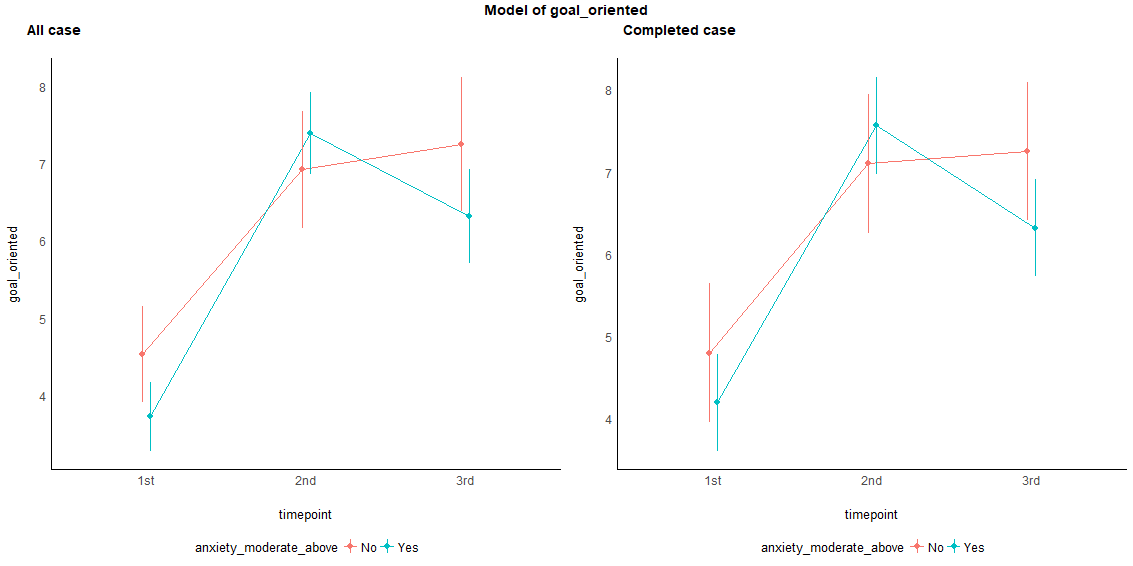

In [30]:
%%R -i sst_data_r -i sst_data_r_completed -w 40 -h 20 --units cm
plt_model_goal_dass_a_yes_all <- plot(estimate_means(model_goal_dass_a_yes_all, at = c("timepoint", "anxiety_moderate_above"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_goal_dass_a_yes_all$layers[[1]] <- NULL
#plt_model_goal_dass_d_all

plt_model_goal_dass_a_yes_completed <- plot(estimate_means(model_goal_dass_a_yes_completed, at = c("timepoint", "anxiety_moderate_above"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_goal_dass_a_yes_completed$layers[[1]] <- NULL
#plt_model_goal_dass_d_completed

ggarrange(plt_model_goal_dass_a_yes_all, plt_model_goal_dass_a_yes_completed,
                    labels = c("All case", "Completed case"),
                    ncol = 2, nrow = 1) %>% annotate_figure(top = text_grob("Model of goal_oriented", face = "bold", size = 14))

### Influence of DASS-S

In [31]:
%%R -i sst_data_r -o model_goal_dass_s_all_result -o model_dominated_dass_s_all_result -o model_confidence_dass_s_all_result -i sst_data_r_completed -o model_goal_dass_s_completed_result -o model_dominated_dass_s_completed_result -o model_confidence_dass_s_completed_result

# All
model_goal_dass_s_all = lmerTest::lmer("goal_oriented ~ 1 + timepoint + dass_s + timepoint * dass_s + (1 | email)", data=sst_data_r)
model_dominated_dass_s_all = lmerTest::lmer("dominated ~ 1 + timepoint + dass_s + timepoint * dass_s + (1 | email)", data=sst_data_r)
model_confidence_dass_s_all = lmerTest::lmer("confidence ~ 1 + timepoint + dass_s + timepoint * dass_s + (1 | email)", data=sst_data_r)

model_goal_dass_s_all_result = summ(model_goal_dass_s_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_dass_s_all_result = summ(model_dominated_dass_s_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_dass_s_all_result = summ(model_confidence_dass_s_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

# Completed
model_goal_dass_s_completed = lmerTest::lmer("goal_oriented ~ 1 + timepoint + dass_s + timepoint * dass_s + (1 | email)", data=sst_data_r_completed)
model_dominated_dass_s_completed = lmerTest::lmer("dominated ~ 1 + timepoint + dass_s + timepoint * dass_s + (1 | email)", data=sst_data_r_completed)
model_confidence_dass_s_completed = lmerTest::lmer("confidence ~ 1 + timepoint + dass_s + timepoint * dass_s + (1 | email)", data=sst_data_r_completed)

model_goal_dass_s_completed_result = summ(model_goal_dass_s_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_dass_s_completed_result = summ(model_dominated_dass_s_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_dass_s_completed_result = summ(model_confidence_dass_s_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

In [32]:
model_goal_dass_s_result = pd.concat([model_goal_dass_s_all_result, model_goal_dass_s_completed_result], axis=1)
model_goal_dass_s_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_dominated_dass_s_result = pd.concat([model_dominated_dass_s_all_result, model_dominated_dass_s_completed_result], axis=1)
model_dominated_dass_s_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_confidence_dass_s_result = pd.concat([model_confidence_dass_s_all_result, model_confidence_dass_s_completed_result], axis=1)
model_confidence_dass_s_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

print('Model of goal_oriented')
model_goal_dass_s_result
print('Model of dominated')
model_dominated_dass_s_result
print('Model of confidence')
model_confidence_dass_s_result

Model of goal_oriented


All case                Completed case              
                        Est.  t val.      p           Est. t val.      p
(Intercept)            5.776  12.204  0.000          6.050  9.423  0.000
timepoint2nd           0.825   1.143  0.255          0.697  0.793  0.429
timepoint3rd           1.087   1.355  0.177          0.820  0.932  0.353
dass_s                -0.079  -4.080  0.000         -0.078 -2.785  0.006
timepoint2nd:dass_s    0.107   3.607  0.000          0.109  2.847  0.005
timepoint3rd:dass_s    0.067   1.965  0.051          0.066  1.731  0.086

Model of dominated


All case                Completed case              
                        Est.  t val.      p           Est. t val.      p
(Intercept)            5.700  12.311  0.000          5.633  8.735  0.000
timepoint2nd          -1.048  -1.557  0.121         -1.520 -1.800  0.074
timepoint3rd          -1.512  -2.007  0.046         -1.510 -1.787  0.076
dass_s                 0.059   3.142  0.002          0.064  2.289  0.023
timepoint2nd:dass_s   -0.019  -0.670  0.504         -0.006 -0.152  0.879
timepoint3rd:dass_s   -0.041  -1.263  0.208         -0.043 -1.171  0.244

Model of confidence


All case                Completed case               
                        Est.  t val.      p           Est.  t val.      p
(Intercept)            5.639  14.221  0.000          5.969  10.934  0.000
timepoint2nd           1.404   2.657  0.009          1.200   1.809  0.073
timepoint3rd           1.400   2.350  0.020          1.169   1.762  0.081
dass_s                -0.070  -4.327  0.000         -0.072  -3.018  0.003
timepoint2nd:dass_s    0.063   2.898  0.004          0.067   2.343  0.021
timepoint3rd:dass_s    0.059   2.332  0.021          0.061   2.127  0.036

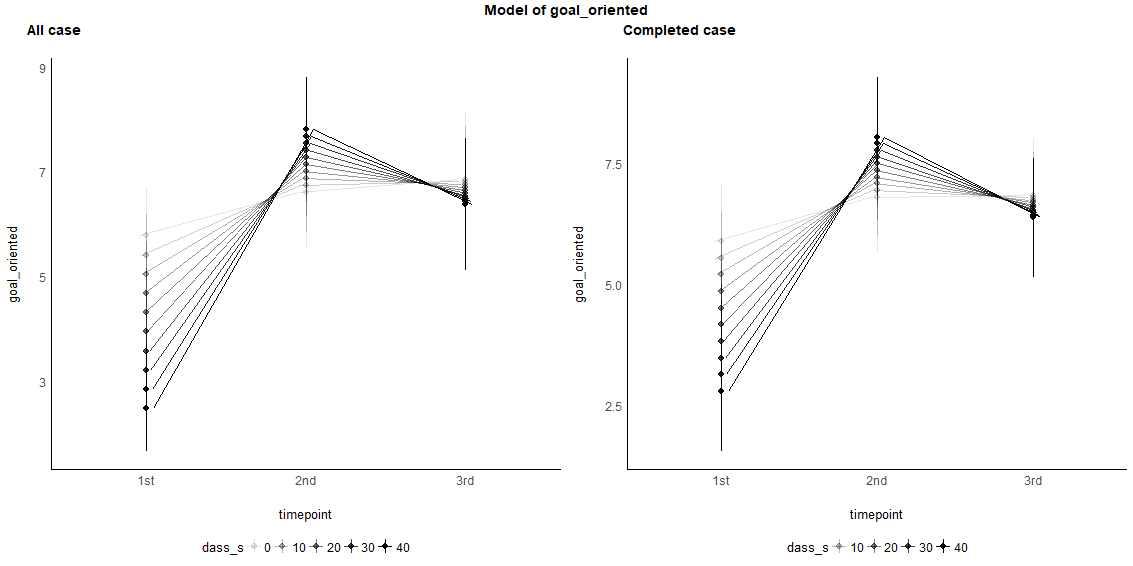

In [33]:
%%R -i sst_data_r -i sst_data_r_completed -w 40 -h 20 --units cm
plt_model_goal_dass_s_all <- plot(estimate_means(model_goal_dass_s_all, at = c("timepoint", "dass_s"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_goal_dass_s_all$layers[[1]] <- NULL
#plt_model_goal_dass_d_all

plt_model_goal_dass_s_completed <- plot(estimate_means(model_goal_dass_s_completed, at = c("timepoint", "dass_s"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_goal_dass_s_completed$layers[[1]] <- NULL
#plt_model_goal_dass_d_completed

ggarrange(plt_model_goal_dass_s_all, plt_model_goal_dass_s_completed,
                    labels = c("All case", "Completed case"),
                    ncol = 2, nrow = 1) %>% annotate_figure(top = text_grob("Model of goal_oriented", face = "bold", size = 14))

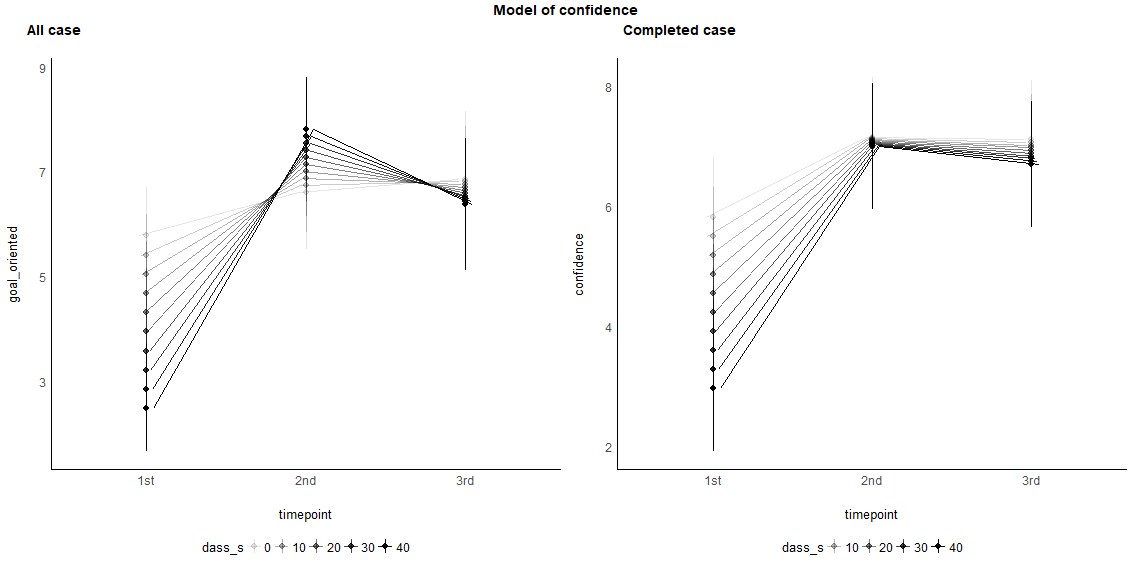

In [34]:
%%R -i sst_data_r -i sst_data_r_completed -w 40 -h 20 --units cm
plt_model_confidence_dass_s_all <- plot(estimate_means(model_confidence_dass_s_all, at = c("timepoint", "dass_s"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_confidence_dass_s_all$layers[[1]] <- NULL
#plt_model_goal_dass_d_all

plt_model_confidence_dass_s_completed <- plot(estimate_means(model_confidence_dass_s_completed, at = c("timepoint", "dass_s"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_confidence_dass_s_completed$layers[[1]] <- NULL
#plt_model_goal_dass_d_completed

ggarrange(plt_model_goal_dass_s_all, plt_model_confidence_dass_s_completed,
                    labels = c("All case", "Completed case"),
                    ncol = 2, nrow = 1) %>% annotate_figure(top = text_grob("Model of confidence", face = "bold", size = 14))

### Influence of DASS-S Clinical

In [35]:
%%R -i sst_data_r -o model_goal_dass_s_yes_all_result -o model_dominated_dass_s_yes_all_result -o model_confidence_dass_s_yes_all_result -i sst_data_r_completed -o model_goal_dass_s_yes_completed_result -o model_dominated_dass_s_yes_completed_result -o model_confidence_dass_s_yes_completed_result

# All
model_goal_dass_s_yes_all = lmerTest::lmer("goal_oriented ~ 1 + timepoint + stress_moderate_above + timepoint * stress_moderate_above + (1 | email)", data=sst_data_r)
model_dominated_dass_s_yes_all = lmerTest::lmer("dominated ~ 1 + timepoint + stress_moderate_above + timepoint * stress_moderate_above + (1 | email)", data=sst_data_r)
model_confidence_dass_s_yes_all = lmerTest::lmer("confidence ~ 1 + timepoint + stress_moderate_above + timepoint * stress_moderate_above + (1 | email)", data=sst_data_r)

model_goal_dass_s_yes_all_result = summ(model_goal_dass_s_yes_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_dass_s_yes_all_result = summ(model_dominated_dass_s_yes_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_dass_s_yes_all_result = summ(model_confidence_dass_s_yes_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

# Completed
model_goal_dass_s_yes_completed = lmerTest::lmer("goal_oriented ~ 1 + timepoint + stress_moderate_above + timepoint * stress_moderate_above + (1 | email)", data=sst_data_r_completed)
model_dominated_dass_s_yes_completed = lmerTest::lmer("dominated ~ 1 + timepoint + stress_moderate_above + timepoint * stress_moderate_above + (1 | email)", data=sst_data_r_completed)
model_confidence_dass_s_yes_completed = lmerTest::lmer("confidence ~ 1 + timepoint + stress_moderate_above + timepoint * stress_moderate_above + (1 | email)", data=sst_data_r_completed)

model_goal_dass_s_yes_completed_result = summ(model_goal_dass_s_yes_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_dass_s_yes_completed_result = summ(model_dominated_dass_s_yes_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_dass_s_yes_completed_result = summ(model_confidence_dass_s_yes_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

In [36]:
model_goal_dass_s_yes_result = pd.concat([model_goal_dass_s_yes_all_result, model_goal_dass_s_yes_completed_result], axis=1)
model_goal_dass_s_yes_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_dominated_dass_s_yes_result = pd.concat([model_dominated_dass_s_yes_all_result, model_dominated_dass_s_yes_completed_result], axis=1)
model_dominated_dass_s_yes_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_confidence_dass_s_yes_result = pd.concat([model_confidence_dass_s_yes_all_result, model_confidence_dass_s_yes_completed_result], axis=1)
model_confidence_dass_s_yes_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

print('Model of goal_oriented')
model_goal_dass_s_yes_result
print('Model of dominated')
model_dominated_dass_s_yes_result
print('Model of confidence')
model_confidence_dass_s_yes_result

Model of goal_oriented


All case                Completed case  \
                                          Est.  t val.      p           Est.   
(Intercept)                              4.814  16.281  0.000          5.000   
timepoint2nd                             2.152   4.829  0.000          2.071   
timepoint3rd                             1.824   3.899  0.000          1.643   
stress_moderate_aboveYes                -1.328  -3.536  0.000         -1.121   
timepoint2nd:stress_moderate_aboveYes    1.793   3.110  0.002          1.747   
timepoint3rd:stress_moderate_aboveYes    1.286   2.073  0.040          1.084   

                                                      
                                       t val.      p  
(Intercept)                            13.929  0.000  
timepoint2nd                            4.218  0.000  
timepoint3rd                            3.345  0.001  
stress_moderate_aboveYes               -2.297  0.023  
timepoint2nd:stress_moderate_aboveYes   2.616  0.010  
timepoint3rd:stress_moderate_aboveYes   1.624  0.107

Model of dominated


All case                Completed case  \
                                          Est.  t val.      p           Est.   
(Intercept)                              6.535  22.581  0.000          6.464   
timepoint2nd                            -1.290  -3.111  0.002         -1.393   
timepoint3rd                            -2.330  -5.331  0.000         -2.286   
stress_moderate_aboveYes                 0.822   2.236  0.026          0.990   
timepoint2nd:stress_moderate_aboveYes   -0.297  -0.553  0.581         -0.456   
timepoint3rd:stress_moderate_aboveYes   -0.111  -0.191  0.849         -0.260   

                                                      
                                       t val.      p  
(Intercept)                            17.909  0.000  
timepoint2nd                           -2.953  0.004  
timepoint3rd                           -4.846  0.000  
stress_moderate_aboveYes                2.018  0.045  
timepoint2nd:stress_moderate_aboveYes  -0.711  0.479  
timepoint3rd:stress_moderate_aboveYes  -0.405  0.686

Model of confidence


All case                Completed case  \
                                          Est.  t val.      p           Est.   
(Intercept)                              4.721  18.968  0.000          4.857   
timepoint2nd                             2.174   6.666  0.000          2.179   
timepoint3rd                             2.183   6.327  0.000          2.107   
stress_moderate_aboveYes                -1.078  -3.409  0.001         -0.766   
timepoint2nd:stress_moderate_aboveYes    1.083   2.556  0.011          0.852   
timepoint3rd:stress_moderate_aboveYes    0.906   1.969  0.051          0.681   

                                                      
                                       t val.      p  
(Intercept)                            15.754  0.000  
timepoint2nd                            5.825  0.000  
timepoint3rd                            5.634  0.000  
stress_moderate_aboveYes               -1.828  0.069  
timepoint2nd:stress_moderate_aboveYes   1.675  0.097  
timepoint3rd:stress_moderate_aboveYes   1.339  0.183

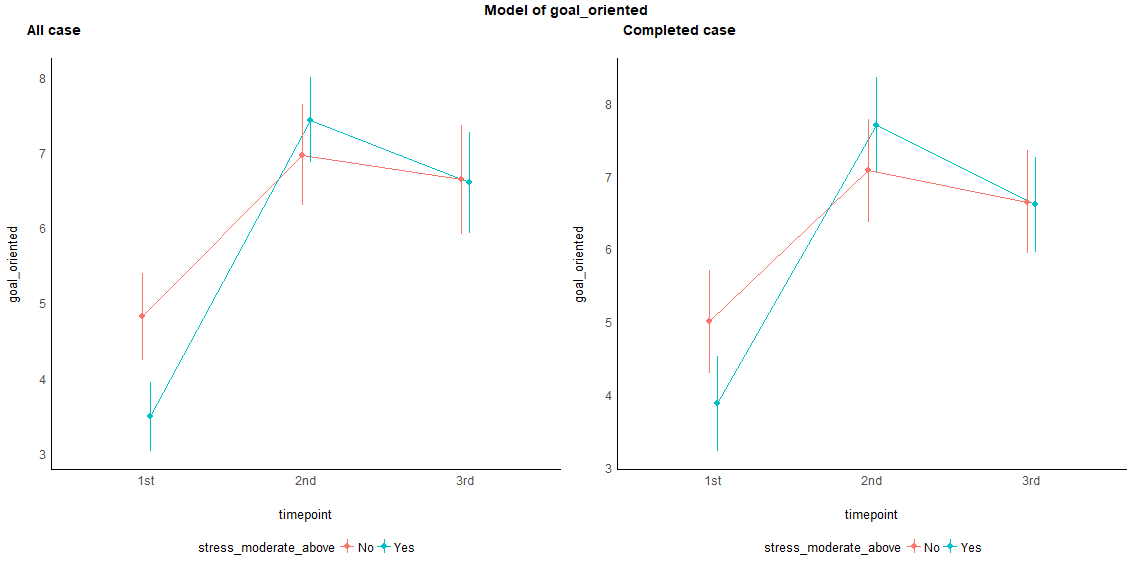

In [37]:
%%R -i sst_data_r -i sst_data_r_completed -w 40 -h 20 --units cm
plt_model_goal_dass_s_yes_all <- plot(estimate_means(model_goal_dass_s_yes_all, at = c("timepoint", "stress_moderate_above"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_goal_dass_s_yes_all$layers[[1]] <- NULL
#plt_model_goal_dass_d_all

plt_model_goal_dass_s_yes_completed <- plot(estimate_means(model_goal_dass_s_yes_completed, at = c("timepoint", "stress_moderate_above"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_goal_dass_s_yes_completed$layers[[1]] <- NULL
#plt_model_goal_dass_d_completed

ggarrange(plt_model_goal_dass_s_yes_all, plt_model_goal_dass_s_yes_completed,
                    labels = c("All case", "Completed case"),
                    ncol = 2, nrow = 1) %>% annotate_figure(top = text_grob("Model of goal_oriented", face = "bold", size = 14))

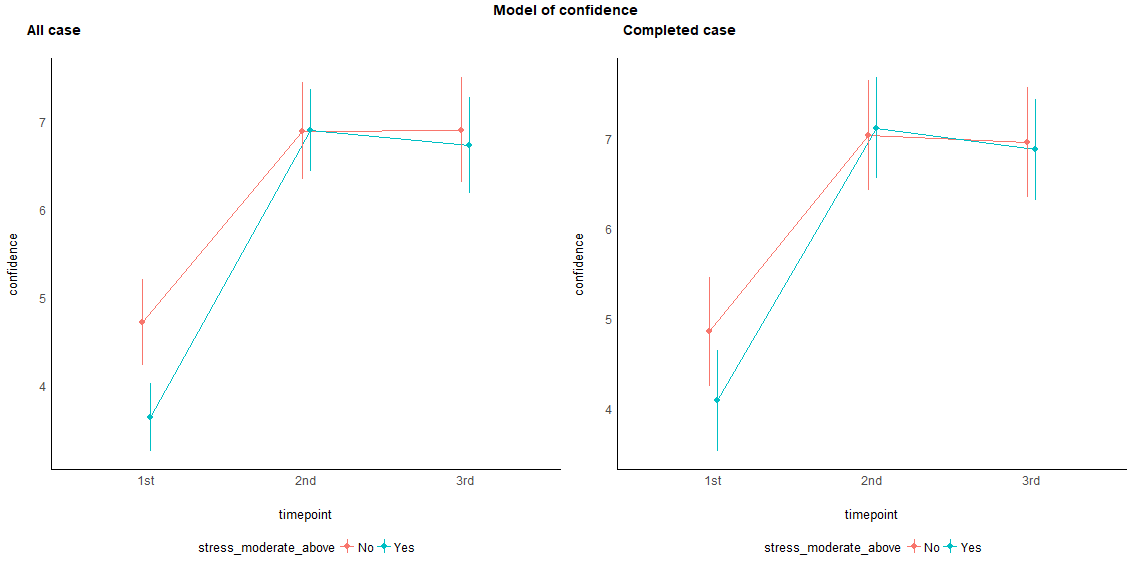

In [38]:
%%R -i sst_data_r -i sst_data_r_completed -w 40 -h 20 --units cm
plt_model_confidence_dass_s_yes_all <- plot(estimate_means(model_confidence_dass_s_yes_all, at = c("timepoint", "stress_moderate_above"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_confidence_dass_s_yes_all$layers[[1]] <- NULL
#plt_model_goal_dass_d_all

plt_model_confidence_dass_s_yes_completed <- plot(estimate_means(model_confidence_dass_s_yes_completed, at = c("timepoint", "stress_moderate_above"))) + theme_modern(legend.position = "bottom") + ggtitle("")
plt_model_confidence_dass_s_yes_completed$layers[[1]] <- NULL
#plt_model_goal_dass_d_completed

ggarrange(plt_model_confidence_dass_s_yes_all, plt_model_confidence_dass_s_yes_completed,
                    labels = c("All case", "Completed case"),
                    ncol = 2, nrow = 1) %>% annotate_figure(top = text_grob("Model of confidence", face = "bold", size = 14))

### Influence of age

In [39]:
%%R -i sst_data_r -o model_goal_age_all_result -o model_dominated_age_all_result -o model_confidence_age_all_result -i sst_data_r_completed -o model_goal_age_completed_result -o model_dominated_age_completed_result -o model_confidence_age_completed_result

# All
model_goal_age_all = lmerTest::lmer("goal_oriented ~ 1 + timepoint + age + timepoint * age + (1 | email)", data=sst_data_r)
model_dominated_age_all = lmerTest::lmer("dominated ~ 1 + timepoint + age + timepoint * age + (1 | email)", data=sst_data_r)
model_confidence_age_all = lmerTest::lmer("confidence ~ 1 + timepoint + age + timepoint * age + (1 | email)", data=sst_data_r)

model_goal_age_all_result = summ(model_goal_age_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_age_all_result = summ(model_dominated_age_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_age_all_result = summ(model_confidence_age_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

# Completed
model_goal_age_completed = lmerTest::lmer("goal_oriented ~ 1 + timepoint + age + timepoint * age + (1 | email)", data=sst_data_r)
model_dominated_age_completed = lmerTest::lmer("dominated ~ 1 + timepoint + age + timepoint * age + (1 | email)", data=sst_data_r)
model_confidence_age_completed = lmerTest::lmer("confidence ~ 1 + timepoint + age + timepoint * age + (1 | email)", data=sst_data_r)

model_goal_age_completed_result = summ(model_goal_age_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_age_completed_result = summ(model_dominated_age_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_age_completed_result = summ(model_confidence_age_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

In [40]:
model_goal_age_result = pd.concat([model_goal_age_all_result, model_goal_age_completed_result], axis=1)
model_goal_age_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_dominated_age_result = pd.concat([model_dominated_age_all_result, model_dominated_age_completed_result], axis=1)
model_dominated_age_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_confidence_age_result = pd.concat([model_confidence_age_all_result, model_confidence_age_completed_result], axis=1)
model_confidence_age_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

print('Model of goal_oriented')
model_goal_age_result
print('Model of dominated')
model_dominated_age_result
print('Model of confidence')
model_confidence_age_result

Model of goal_oriented


All case               Completed case              
                     Est. t val.      p           Est. t val.      p
(Intercept)         3.379  4.741  0.000          3.379  4.741  0.000
timepoint2nd        3.738  3.348  0.001          3.738  3.348  0.001
timepoint3rd        3.091  2.659  0.009          3.091  2.659  0.009
age                 0.013  0.864  0.388          0.013  0.864  0.388
timepoint2nd:age   -0.011 -0.457  0.649         -0.011 -0.457  0.649
timepoint3rd:age   -0.009 -0.375  0.708         -0.009 -0.375  0.708

Model of dominated


All case                Completed case               
                     Est.  t val.      p           Est.  t val.      p
(Intercept)         7.569  10.838  0.000          7.569  10.838  0.000
timepoint2nd       -1.934  -1.876  0.062         -1.934  -1.876  0.062
timepoint3rd       -2.826  -2.624  0.009         -2.826  -2.624  0.009
age                -0.013  -0.851  0.396         -0.013  -0.851  0.396
timepoint2nd:age    0.011   0.517  0.605          0.011   0.517  0.605
timepoint3rd:age    0.008   0.369  0.713          0.008   0.369  0.713

Model of confidence


All case               Completed case              
                     Est. t val.      p           Est. t val.      p
(Intercept)         4.587  7.386  0.000          4.587  7.386  0.000
timepoint2nd        2.203  2.646  0.009          2.203  2.646  0.009
timepoint3rd        2.828  3.243  0.001          2.828  3.243  0.001
age                -0.011 -0.782  0.435         -0.011 -0.782  0.435
timepoint2nd:age    0.012  0.691  0.491          0.012  0.691  0.491
timepoint3rd:age   -0.003 -0.177  0.860         -0.003 -0.177  0.860

### Influence of gender

In [41]:
%%R -i sst_data_r -o model_goal_gender_all_result -o model_dominated_gender_all_result -o model_confidence_gender_all_result -i sst_data_r_completed -o model_goal_gender_completed_result -o model_dominated_gender_completed_result -o model_confidence_gender_completed_result

# All
model_goal_gender_all = lmerTest::lmer("goal_oriented ~ 1 + timepoint + gender + timepoint * gender + (1 | email)", data=sst_data_r)
model_dominated_gender_all = lmerTest::lmer("dominated ~ 1 + timepoint + gender + timepoint * gender + (1 | email)", data=sst_data_r)
model_confidence_gender_all = lmerTest::lmer("confidence ~ 1 + timepoint + gender + timepoint * gender + (1 | email)", data=sst_data_r)

model_goal_gender_all_result = summ(model_goal_gender_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_gender_all_result = summ(model_dominated_gender_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_gender_all_result = summ(model_confidence_gender_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

# Completed
model_goal_gender_completed = lmerTest::lmer("goal_oriented ~ 1 + timepoint + gender + timepoint * gender + (1 | email)", data=sst_data_r_completed)
model_dominated_gender_completed = lmerTest::lmer("dominated ~ 1 + timepoint + gender + timepoint * gender + (1 | email)", data=sst_data_r_completed)
model_confidence_gender_completed = lmerTest::lmer("confidence ~ 1 + timepoint + gender + timepoint * gender + (1 | email)", data=sst_data_r_completed)

model_goal_gender_completed_result = summ(model_goal_gender_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_gender_completed_result = summ(model_dominated_gender_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_gender_completed_result = summ(model_confidence_gender_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

In [42]:
model_goal_gender_result = pd.concat([model_goal_gender_all_result, model_goal_gender_completed_result], axis=1)
model_goal_gender_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_dominated_gender_result = pd.concat([model_dominated_gender_all_result, model_dominated_gender_completed_result], axis=1)
model_dominated_gender_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_confidence_gender_result = pd.concat([model_confidence_gender_all_result, model_confidence_gender_completed_result], axis=1)
model_confidence_gender_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

print('Model of goal_oriented')
model_goal_gender_result
print('Model of dominated')
model_dominated_gender_result
print('Model of confidence')
model_confidence_gender_result

Model of goal_oriented


All case                Completed case               
                            Est.  t val.      p           Est.  t val.      p
(Intercept)                4.071  20.460  0.000          4.385  16.411  0.000
timepoint2nd               3.245  10.369  0.000          3.115   8.470  0.000
timepoint3rd               2.695   7.990  0.000          2.385   6.483  0.000
genderMale                -0.463  -1.014  0.312         -0.112  -0.175  0.861
timepoint2nd:genderMale    0.011   0.015  0.988         -0.479  -0.544  0.587
timepoint3rd:genderMale   -0.126  -0.158  0.874         -0.476  -0.540  0.590

Model of dominated


All case                Completed case               
                            Est.  t val.      p           Est.  t val.      p
(Intercept)                7.023  35.934  0.000          7.154  26.768  0.000
timepoint2nd              -1.464  -5.123  0.000         -1.731  -5.072  0.000
timepoint3rd              -2.657  -8.569  0.000         -2.788  -8.172  0.000
genderMale                -0.197  -0.441  0.660         -1.245  -1.946  0.053
timepoint2nd:genderMale    0.241   0.365  0.715          1.003   1.229  0.222
timepoint3rd:genderMale    1.203   1.640  0.103          2.061   2.524  0.013

Model of confidence


All case                Completed case               
                            Est.  t val.      p           Est.  t val.      p
(Intercept)                4.144  23.807  0.000          4.462  19.230  0.000
timepoint2nd               2.897  12.473  0.000          2.712   9.837  0.000
timepoint3rd               2.669  10.545  0.000          2.462   8.930  0.000
genderMale                -0.057  -0.142  0.887          0.175   0.315  0.753
timepoint2nd:genderMale   -0.840  -1.562  0.120         -0.802  -1.216  0.226
timepoint3rd:genderMale   -0.080  -0.133  0.894         -0.189  -0.286  0.775

### Influence of edu

In [43]:
%%R -i sst_data_r -o model_goal_edu_all_result -o model_dominated_edu_all_result -o model_confidence_edu_all_result -i sst_data_r_completed -o model_goal_edu_completed_result -o model_dominated_edu_completed_result -o model_confidence_edu_completed_result

# All
model_goal_edu_all = lmerTest::lmer("goal_oriented ~ 1 + timepoint + edu + timepoint * edu + (1 | email)", data=sst_data_r)
model_dominated_edu_all = lmerTest::lmer("dominated ~ 1 + timepoint + edu + timepoint * edu + (1 | email)", data=sst_data_r)
model_confidence_edu_all = lmerTest::lmer("confidence ~ 1 + timepoint + edu + timepoint * edu + (1 | email)", data=sst_data_r)

model_goal_edu_all_result = summ(model_goal_edu_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_edu_all_result = summ(model_dominated_edu_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_edu_all_result = summ(model_confidence_edu_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

# Completed
model_goal_edu_completed = lmerTest::lmer("goal_oriented ~ 1 + timepoint + edu + timepoint * edu + (1 | email)", data=sst_data_r_completed)
model_dominated_edu_completed = lmerTest::lmer("dominated ~ 1 + timepoint + edu + timepoint * edu + (1 | email)", data=sst_data_r_completed)
model_confidence_edu_completed = lmerTest::lmer("confidence ~ 1 + timepoint + edu + timepoint * edu + (1 | email)", data=sst_data_r_completed)

model_goal_edu_completed_result = summ(model_goal_edu_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_edu_completed_result = summ(model_dominated_edu_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_edu_completed_result = summ(model_confidence_edu_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

In [44]:
model_goal_edu_result = pd.concat([model_goal_edu_all_result, model_goal_edu_completed_result], axis=1)
model_goal_edu_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_dominated_edu_result = pd.concat([model_dominated_edu_all_result, model_dominated_edu_completed_result], axis=1)
model_dominated_edu_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_confidence_edu_result = pd.concat([model_confidence_edu_all_result, model_confidence_edu_completed_result], axis=1)
model_confidence_edu_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

print('Model of goal_oriented')
model_goal_edu_result
print('Model of dominated')
model_dominated_edu_result
print('Model of confidence')
model_confidence_edu_result

Model of goal_oriented


All case                 \
                                                       Est.  t val.      p   
(Intercept)                                           4.102  15.797  0.000   
timepoint2nd                                          3.107   7.777  0.000   
timepoint3rd                                          2.897   6.621  0.000   
eduDiploma/ Associate Degree/ Higher Diploma         -0.002  -0.003  0.997   
eduSecondary or below                                -0.269  -0.600  0.549   
timepoint2nd:eduDiploma/ Associate Degree/ High...   -0.708  -0.853  0.395   
timepoint3rd:eduDiploma/ Associate Degree/ High...   -0.555  -0.608  0.544   
timepoint2nd:eduSecondary or below                    0.849   1.199  0.232   
timepoint3rd:eduSecondary or below                   -0.231  -0.305  0.760   

                                                   Completed case          \
                                                             Est.  t val.   
(Intercept)                                                 4.469  13.011   
timepoint2nd                                                3.000   6.318   
timepoint3rd                                                2.531   5.331   
eduDiploma/ Associate Degree/ Higher Diploma                0.087   0.118   
eduSecondary or below                                      -0.094  -0.158   
timepoint2nd:eduDiploma/ Associate Degree/ High...         -0.556  -0.548   
timepoint3rd:eduDiploma/ Associate Degree/ High...         -0.642  -0.634   
timepoint2nd:eduSecondary or below                          0.313   0.380   
timepoint3rd:eduSecondary or below                         -0.406  -0.494   

                                                           
                                                        p  
(Intercept)                                         0.000  
timepoint2nd                                        0.000  
timepoint3rd                                        0.000  
eduDiploma/ Associate Degree/ Higher Diploma        0.906  
eduSecondary or below                               0.875  
timepoint2nd:eduDiploma/ Associate Degree/ High...  0.585  
timepoint3rd:eduDiploma/ Associate Degree/ High...  0.528  
timepoint2nd:eduSecondary or below                  0.705  
timepoint3rd:eduSecondary or below                  0.622

Model of dominated


All case                 \
                                                       Est.  t val.      p   
(Intercept)                                           6.983  27.514  0.000   
timepoint2nd                                         -1.168  -3.233  0.001   
timepoint3rd                                         -2.672  -6.694  0.000   
eduDiploma/ Associate Degree/ Higher Diploma          0.467   0.926  0.356   
eduSecondary or below                                 0.060   0.137  0.891   
timepoint2nd:eduDiploma/ Associate Degree/ High...   -0.082  -0.108  0.914   
timepoint3rd:eduDiploma/ Associate Degree/ High...    0.728   0.871  0.385   
timepoint2nd:eduSecondary or below                   -1.219  -1.897  0.060   
timepoint3rd:eduSecondary or below                    0.024   0.034  0.973   

                                                   Completed case          \
                                                             Est.  t val.   
(Intercept)                                                 6.938  19.964   
timepoint2nd                                               -1.281  -2.892   
timepoint3rd                                               -2.656  -5.995   
eduDiploma/ Associate Degree/ Higher Diploma                0.285   0.384   
eduSecondary or below                                       0.125   0.208   
timepoint2nd:eduDiploma/ Associate Degree/ High...          0.059   0.062   
timepoint3rd:eduDiploma/ Associate Degree/ High...          0.878   0.929   
timepoint2nd:eduSecondary or below                         -1.281  -1.670   
timepoint3rd:eduSecondary or below                         -0.031  -0.041   

                                                           
                                                        p  
(Intercept)                                         0.000  
timepoint2nd                                        0.005  
timepoint3rd                                        0.000  
eduDiploma/ Associate Degree/ Higher Diploma        0.702  
eduSecondary or below                               0.836  
timepoint2nd:eduDiploma/ Associate Degree/ High...  0.950  
timepoint3rd:eduDiploma/ Associate Degree/ High...  0.355  
timepoint2nd:eduSecondary or below                  0.098  
timepoint3rd:eduSecondary or below                  0.968

Model of confidence


All case                 \
                                                       Est.  t val.      p   
(Intercept)                                           4.271  19.244  0.000   
timepoint2nd                                          2.830   9.730  0.000   
timepoint3rd                                          2.890   8.942  0.000   
eduDiploma/ Associate Degree/ Higher Diploma         -0.471  -1.068  0.287   
eduSecondary or below                                -0.373  -0.970  0.333   
timepoint2nd:eduDiploma/ Associate Degree/ High...   -0.930  -1.523  0.130   
timepoint3rd:eduDiploma/ Associate Degree/ High...   -0.208  -0.306  0.760   
timepoint2nd:eduSecondary or below                    0.527   1.015  0.312   
timepoint3rd:eduSecondary or below                   -0.260  -0.463  0.644   

                                                   Completed case          \
                                                             Est.  t val.   
(Intercept)                                                 4.500  15.431   
timepoint2nd                                                2.750   7.807   
timepoint3rd                                                2.750   7.807   
eduDiploma/ Associate Degree/ Higher Diploma                0.278   0.446   
eduSecondary or below                                      -0.250  -0.495   
timepoint2nd:eduDiploma/ Associate Degree/ High...         -1.083  -1.441   
timepoint3rd:eduDiploma/ Associate Degree/ High...         -0.639  -0.850   
timepoint2nd:eduSecondary or below                          0.313   0.512   
timepoint3rd:eduSecondary or below                         -0.375  -0.615   

                                                           
                                                        p  
(Intercept)                                         0.000  
timepoint2nd                                        0.000  
timepoint3rd                                        0.000  
eduDiploma/ Associate Degree/ Higher Diploma        0.656  
eduSecondary or below                               0.621  
timepoint2nd:eduDiploma/ Associate Degree/ High...  0.153  
timepoint3rd:eduDiploma/ Associate Degree/ High...  0.397  
timepoint2nd:eduSecondary or below                  0.610  
timepoint3rd:eduSecondary or below                  0.540

### Application to service

In [45]:
%%R -i sst_data_r -o model_goal_service_application_all_result -o model_dominated_service_application_all_result -o model_confidence_service_application_all_result -i sst_data_r_completed -o model_goal_service_application_completed_result -o model_dominated_service_application_completed_result -o model_confidence_service_application_completed_result

# All
model_goal_service_application_all = lmerTest::lmer("goal_oriented ~ 1 + timepoint + service_application + timepoint * service_application + (1 | email)", data=sst_data_r)
model_dominated_service_application_all = lmerTest::lmer("dominated ~ 1 + timepoint + service_application + timepoint * service_application + (1 | email)", data=sst_data_r)
model_confidence_service_application_all = lmerTest::lmer("confidence ~ 1 + timepoint + service_application + timepoint * service_application + (1 | email)", data=sst_data_r)

model_goal_service_application_all_result = summ(model_goal_service_application_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_service_application_all_result = summ(model_dominated_service_application_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_service_application_all_result = summ(model_confidence_service_application_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

# Completed
model_goal_service_application_completed = lmerTest::lmer("goal_oriented ~ 1 + timepoint + service_application + timepoint * service_application + (1 | email)", data=sst_data_r_completed)
model_dominated_service_application_completed = lmerTest::lmer("dominated ~ 1 + timepoint + service_application + timepoint * service_application + (1 | email)", data=sst_data_r_completed)
model_confidence_service_application_completed = lmerTest::lmer("confidence ~ 1 + timepoint + service_application + timepoint * service_application + (1 | email)", data=sst_data_r_completed)

model_goal_service_application_completed_result = summ(model_goal_service_application_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_service_application_completed_result = summ(model_dominated_service_application_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_service_application_completed_result = summ(model_confidence_service_application_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

R[write to console]: boundary (singular) fit: see help('isSingular')



In [46]:
model_goal_service_application_result = pd.concat([model_goal_service_application_all_result, model_goal_service_application_completed_result], axis=1)
model_goal_service_application_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_dominated_service_application_result = pd.concat([model_dominated_service_application_all_result, model_dominated_service_application_completed_result], axis=1)
model_dominated_service_application_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_confidence_service_application_result = pd.concat([model_confidence_service_application_all_result, model_confidence_service_application_completed_result], axis=1)
model_confidence_service_application_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

print('Model of goal_oriented')
model_goal_service_application_result
print('Model of dominated')
model_dominated_service_application_result
print('Model of confidence')
model_confidence_service_application_result

Model of goal_oriented


All case                Completed case  \
                                     Est.  t val.      p           Est.   
(Intercept)                         3.715  10.295  0.000          3.932   
timepoint2nd                        3.204   5.888  0.000          3.242   
timepoint3rd                        3.019   5.204  0.000          2.803   
service_application                 0.015   1.180  0.239          0.018   
timepoint2nd:service_application   -0.002  -0.112  0.911         -0.009   
timepoint3rd:service_application   -0.019  -0.992  0.322         -0.022   

                                                
                                 t val.      p  
(Intercept)                       8.923  0.000  
timepoint2nd                      5.324  0.000  
timepoint3rd                      4.604  0.000  
service_application               1.264  0.208  
timepoint2nd:service_application -0.447  0.656  
timepoint3rd:service_application -1.136  0.258

Model of dominated


All case                Completed case  \
                                     Est.  t val.      p           Est.   
(Intercept)                         7.542  21.803  0.000          7.775   
timepoint2nd                       -1.916  -3.925  0.000         -2.533   
timepoint3rd                       -2.493  -4.762  0.000         -2.745   
service_application                -0.020  -1.692  0.092         -0.030   
timepoint2nd:service_application    0.017   1.059  0.291          0.034   
timepoint3rd:service_application    0.003   0.163  0.871          0.012   

                                                 
                                  t val.      p  
(Intercept)                       17.721  0.000  
timepoint2nd                      -4.495  0.000  
timepoint3rd                      -4.869  0.000  
service_application               -2.130  0.035  
timepoint2nd:service_application   1.913  0.058  
timepoint3rd:service_application   0.681  0.497

Model of confidence


All case                Completed case  \
                                     Est.  t val.      p           Est.   
(Intercept)                         3.796  12.453  0.000          4.131   
timepoint2nd                        2.671   6.729  0.000          2.551   
timepoint3rd                        2.785   6.512  0.000          2.570   
service_application                 0.011   1.082  0.280          0.012   
timepoint2nd:service_application    0.005   0.416  0.678          0.003   
timepoint3rd:service_application   -0.003  -0.201  0.841         -0.004   

                                                 
                                  t val.      p  
(Intercept)                       11.053  0.000  
timepoint2nd                       5.563  0.000  
timepoint3rd                       5.605  0.000  
service_application                1.006  0.316  
timepoint2nd:service_application   0.232  0.817  
timepoint3rd:service_application  -0.249  0.804

### Enquiry to service

In [47]:
%%R -i sst_data_r -o model_goal_service_enquiry_all_result -o model_dominated_service_enquiry_all_result -o model_confidence_service_enquiry_all_result -i sst_data_r_completed -o model_goal_service_enquiry_completed_result -o model_dominated_service_enquiry_completed_result -o model_confidence_service_enquiry_completed_result

# All
model_goal_service_enquiry_all = lmerTest::lmer("goal_oriented ~ 1 + timepoint + service_enquiry + timepoint * service_enquiry + (1 | email)", data=sst_data_r)
model_dominated_service_enquiry_all = lmerTest::lmer("dominated ~ 1 + timepoint + service_enquiry + timepoint * service_enquiry + (1 | email)", data=sst_data_r)
model_confidence_service_enquiry_all = lmerTest::lmer("confidence ~ 1 + timepoint + service_enquiry + timepoint * service_enquiry + (1 | email)", data=sst_data_r)

model_goal_service_enquiry_all_result = summ(model_goal_service_enquiry_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_service_enquiry_all_result = summ(model_dominated_service_enquiry_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_service_enquiry_all_result = summ(model_confidence_service_enquiry_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

# Completed
model_goal_service_enquiry_completed = lmerTest::lmer("goal_oriented ~ 1 + timepoint + service_enquiry + timepoint * service_enquiry + (1 | email)", data=sst_data_r_completed)
model_dominated_service_enquiry_completed = lmerTest::lmer("dominated ~ 1 + timepoint + service_enquiry + timepoint * service_enquiry + (1 | email)", data=sst_data_r_completed)
model_confidence_service_enquiry_completed = lmerTest::lmer("confidence ~ 1 + timepoint + service_enquiry + timepoint * service_enquiry + (1 | email)", data=sst_data_r_completed)

model_goal_service_enquiry_completed_result = summ(model_goal_service_enquiry_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_service_enquiry_completed_result = summ(model_dominated_service_enquiry_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_service_enquiry_completed_result = summ(model_confidence_service_enquiry_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

In [48]:
model_goal_service_enquiry_result = pd.concat([model_goal_service_enquiry_all_result, model_goal_service_enquiry_completed_result], axis=1)
model_goal_service_enquiry_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_dominated_service_enquiry_result = pd.concat([model_dominated_service_enquiry_all_result, model_dominated_service_enquiry_completed_result], axis=1)
model_dominated_service_enquiry_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_confidence_service_enquiry_result = pd.concat([model_confidence_service_enquiry_all_result, model_confidence_service_enquiry_completed_result], axis=1)
model_confidence_service_enquiry_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

print('Model of goal_oriented')
model_goal_service_enquiry_result
print('Model of dominated')
model_dominated_service_enquiry_result
print('Model of confidence')
model_confidence_service_enquiry_result

Model of goal_oriented


All case                Completed case          \
                                 Est.  t val.      p           Est.  t val.   
(Intercept)                     3.939  13.008  0.000          4.133  11.332   
timepoint2nd                    3.116   6.876  0.000          3.118   6.212   
timepoint3rd                    2.604   5.412  0.000          2.413   4.807   
service_enquiry                 0.007   0.535  0.593          0.012   0.855   
timepoint2nd:service_enquiry    0.003   0.141  0.888         -0.005  -0.231   
timepoint3rd:service_enquiry   -0.000  -0.020  0.984         -0.006  -0.298   

                                     
                                  p  
(Intercept)                   0.000  
timepoint2nd                  0.000  
timepoint3rd                  0.000  
service_enquiry               0.394  
timepoint2nd:service_enquiry  0.817  
timepoint3rd:service_enquiry  0.766

Model of dominated


All case                Completed case          \
                                 Est.  t val.      p           Est.  t val.   
(Intercept)                     7.195  24.658  0.000          7.314  20.001   
timepoint2nd                   -1.733  -4.234  0.000         -2.106  -4.471   
timepoint3rd                   -2.302  -5.270  0.000         -2.437  -5.175   
service_enquiry                -0.010  -0.822  0.412         -0.020  -1.384   
timepoint2nd:service_enquiry    0.015   0.937  0.350          0.029   1.567   
timepoint3rd:service_enquiry   -0.009  -0.496  0.620          0.000   0.025   

                                     
                                  p  
(Intercept)                   0.000  
timepoint2nd                  0.000  
timepoint3rd                  0.000  
service_enquiry               0.168  
timepoint2nd:service_enquiry  0.120  
timepoint3rd:service_enquiry  0.980

Model of confidence


All case                Completed case          \
                                 Est.  t val.      p           Est.  t val.   
(Intercept)                     3.771  14.612  0.000          4.006  12.887   
timepoint2nd                    2.824   8.534  0.000          2.756   7.303   
timepoint3rd                    2.751   7.752  0.000          2.607   6.909   
service_enquiry                 0.018   1.701  0.090          0.026   2.099   
timepoint2nd:service_enquiry   -0.003  -0.253  0.801         -0.010  -0.655   
timepoint3rd:service_enquiry   -0.004  -0.277  0.782         -0.009  -0.635   

                                     
                                  p  
(Intercept)                   0.000  
timepoint2nd                  0.000  
timepoint3rd                  0.000  
service_enquiry               0.037  
timepoint2nd:service_enquiry  0.514  
timepoint3rd:service_enquiry  0.527

### Application to enquiry

In [49]:
%%R -i sst_data_r -o model_goal_enquiry_application_all_result -o model_dominated_enquiry_application_all_result -o model_confidence_enquiry_application_all_result -i sst_data_r_completed -o model_goal_enquiry_application_completed_result -o model_dominated_enquiry_application_completed_result -o model_confidence_enquiry_application_completed_result

# All
model_goal_enquiry_application_all = lmerTest::lmer("goal_oriented ~ 1 + timepoint + enquiry_application + timepoint * enquiry_application + (1 | email)", data=sst_data_r)
model_dominated_enquiry_application_all = lmerTest::lmer("dominated ~ 1 + timepoint + enquiry_application + timepoint * enquiry_application + (1 | email)", data=sst_data_r)
model_confidence_enquiry_application_all = lmerTest::lmer("confidence ~ 1 + timepoint + enquiry_application + timepoint * enquiry_application + (1 | email)", data=sst_data_r)

model_goal_enquiry_application_all_result = summ(model_goal_enquiry_application_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_enquiry_application_all_result = summ(model_dominated_enquiry_application_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_enquiry_application_all_result = summ(model_confidence_enquiry_application_all)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

# Completed
model_goal_enquiry_application_completed = lmerTest::lmer("goal_oriented ~ 1 + timepoint + enquiry_application + timepoint * enquiry_application + (1 | email)", data=sst_data_r_completed)
model_dominated_enquiry_application_completed = lmerTest::lmer("dominated ~ 1 + timepoint + enquiry_application + timepoint * enquiry_application + (1 | email)", data=sst_data_r_completed)
model_confidence_enquiry_application_completed = lmerTest::lmer("confidence ~ 1 + timepoint + enquiry_application + timepoint * enquiry_application + (1 | email)", data=sst_data_r_completed)

model_goal_enquiry_application_completed_result = summ(model_goal_enquiry_application_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_dominated_enquiry_application_completed_result = summ(model_dominated_enquiry_application_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)
model_confidence_enquiry_application_completed_result = summ(model_confidence_enquiry_application_completed)$coeftable %>% round(3) %>% as.data.frame() %>% select(-S.E., -d.f.)

R[write to console]: boundary (singular) fit: see help('isSingular')



In [50]:
model_goal_enquiry_application_result = pd.concat([model_goal_enquiry_application_all_result, model_goal_enquiry_application_completed_result], axis=1)
model_goal_enquiry_application_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_dominated_enquiry_application_result = pd.concat([model_dominated_enquiry_application_all_result, model_dominated_enquiry_application_completed_result], axis=1)
model_dominated_enquiry_application_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

model_confidence_enquiry_application_result = pd.concat([model_confidence_enquiry_application_all_result, model_confidence_enquiry_application_completed_result], axis=1)
model_confidence_enquiry_application_result.columns = pd.MultiIndex.from_product([['All case', 'Completed case'],['Est.', 't val.', 'p']])

print('Model of goal_oriented')
model_goal_enquiry_application_result
print('Model of dominated')
model_dominated_enquiry_application_result
print('Model of confidence')
model_confidence_enquiry_application_result

Model of goal_oriented


All case                Completed case  \
                                     Est.  t val.      p           Est.   
(Intercept)                         3.496  13.587  0.000          3.877   
timepoint2nd                        3.519   8.692  0.000          3.365   
timepoint3rd                        3.169   7.072  0.000          2.788   
enquiry_application                 0.071   2.609  0.010          0.062   
timepoint2nd:enquiry_application   -0.041  -1.009  0.314         -0.042   
timepoint3rd:enquiry_application   -0.076  -1.806  0.072         -0.067   

                                                 
                                  t val.      p  
(Intercept)                       10.859  0.000  
timepoint2nd                       6.810  0.000  
timepoint3rd                       5.644  0.000  
enquiry_application                1.989  0.048  
timepoint2nd:enquiry_application  -0.969  0.335  
timepoint3rd:enquiry_application  -1.555  0.123

Model of dominated


All case                Completed case  \
                                     Est.  t val.      p           Est.   
(Intercept)                         7.398  29.714  0.000          7.444   
timepoint2nd                       -1.465  -3.943  0.000         -1.847   
timepoint3rd                       -2.415  -5.827  0.000         -2.492   
enquiry_application                -0.050  -1.887  0.060         -0.054   
timepoint2nd:enquiry_application   -0.002  -0.042  0.967          0.025   
timepoint3rd:enquiry_application    0.002   0.054  0.957          0.008   

                                                 
                                  t val.      p  
(Intercept)                       20.789  0.000  
timepoint2nd                      -3.963  0.000  
timepoint3rd                      -5.347  0.000  
enquiry_application               -1.706  0.090  
timepoint2nd:enquiry_application   0.612  0.541  
timepoint3rd:enquiry_application   0.194  0.847

Model of confidence


All case                Completed case  \
                                     Est.  t val.      p           Est.   
(Intercept)                         3.763  17.246  0.000          4.218   
timepoint2nd                        2.924   9.751  0.000          2.711   
timepoint3rd                        2.964   8.807  0.000          2.660   
enquiry_application                 0.040   1.729  0.085          0.027   
timepoint2nd:enquiry_application   -0.013  -0.428  0.669         -0.009   
timepoint3rd:enquiry_application   -0.030  -0.979  0.329         -0.022   

                                                 
                                  t val.      p  
(Intercept)                       13.778  0.000  
timepoint2nd                       7.257  0.000  
timepoint3rd                       7.120  0.000  
enquiry_application                1.009  0.315  
timepoint2nd:enquiry_application  -0.262  0.794  
timepoint3rd:enquiry_application  -0.678  0.499

## Change distribution

In [51]:
sst_data_r_goal_oriented_wide = sst_data_r.pivot_table(index='email',columns='timepoint',values='goal_oriented').reset_index()
sst_data_r_goal_oriented_wide['3rd_1st'] = sst_data_r_goal_oriented_wide['3rd'] - sst_data_r_goal_oriented_wide['1st']
sst_data_r_goal_oriented_wide['2nd_1st'] = sst_data_r_goal_oriented_wide['2nd'] - sst_data_r_goal_oriented_wide['1st']
sst_data_r_goal_oriented_wide['outcome'] = 'goal_oriented'

sst_data_r_dominated_wide = sst_data_r.pivot_table(index='email',columns='timepoint',values='dominated').reset_index()
sst_data_r_dominated_wide['3rd_1st'] = sst_data_r_dominated_wide['3rd'] - sst_data_r_dominated_wide['1st']
sst_data_r_dominated_wide['2nd_1st'] = sst_data_r_dominated_wide['2nd'] - sst_data_r_dominated_wide['1st']
sst_data_r_dominated_wide['outcome'] = 'dominated'

sst_data_r_confidence_wide = sst_data_r.pivot_table(index='email',columns='timepoint',values='confidence').reset_index()
sst_data_r_confidence_wide['3rd_1st'] = sst_data_r_confidence_wide['3rd'] - sst_data_r_confidence_wide['1st']
sst_data_r_confidence_wide['2nd_1st'] = sst_data_r_confidence_wide['2nd'] - sst_data_r_confidence_wide['1st']
sst_data_r_confidence_wide['outcome'] = 'confidence'

sst_data_r_wide = pd.concat([sst_data_r_goal_oriented_wide,sst_data_r_dominated_wide,sst_data_r_confidence_wide]).reset_index()


sst_data_r_completed_goal_oriented_wide = sst_data_r_completed.pivot_table(index='email',columns='timepoint',values='goal_oriented').reset_index()
sst_data_r_completed_goal_oriented_wide['3rd_1st'] = sst_data_r_completed_goal_oriented_wide['3rd'] - sst_data_r_completed_goal_oriented_wide['1st']
sst_data_r_completed_goal_oriented_wide['2nd_1st'] = sst_data_r_completed_goal_oriented_wide['2nd'] - sst_data_r_completed_goal_oriented_wide['1st']
sst_data_r_completed_goal_oriented_wide['outcome'] = 'goal_oriented'

sst_data_r_completed_dominated_wide = sst_data_r_completed.pivot_table(index='email',columns='timepoint',values='dominated').reset_index()
sst_data_r_completed_dominated_wide['3rd_1st'] = sst_data_r_completed_dominated_wide['3rd'] - sst_data_r_completed_dominated_wide['1st']
sst_data_r_completed_dominated_wide['2nd_1st'] = sst_data_r_completed_dominated_wide['2nd'] - sst_data_r_completed_dominated_wide['1st']
sst_data_r_completed_dominated_wide['outcome'] = 'dominated'

sst_data_r_completed_confidence_wide = sst_data_r_completed.pivot_table(index='email',columns='timepoint',values='confidence').reset_index()
sst_data_r_completed_confidence_wide['3rd_1st'] = sst_data_r_completed_confidence_wide['3rd'] - sst_data_r_completed_confidence_wide['1st']
sst_data_r_completed_confidence_wide['2nd_1st'] = sst_data_r_completed_confidence_wide['2nd'] - sst_data_r_completed_confidence_wide['1st']
sst_data_r_completed_confidence_wide['outcome'] = 'confidence'

sst_data_r_completed_wide = pd.concat([sst_data_r_completed_goal_oriented_wide,sst_data_r_completed_dominated_wide,sst_data_r_completed_confidence_wide]).reset_index()

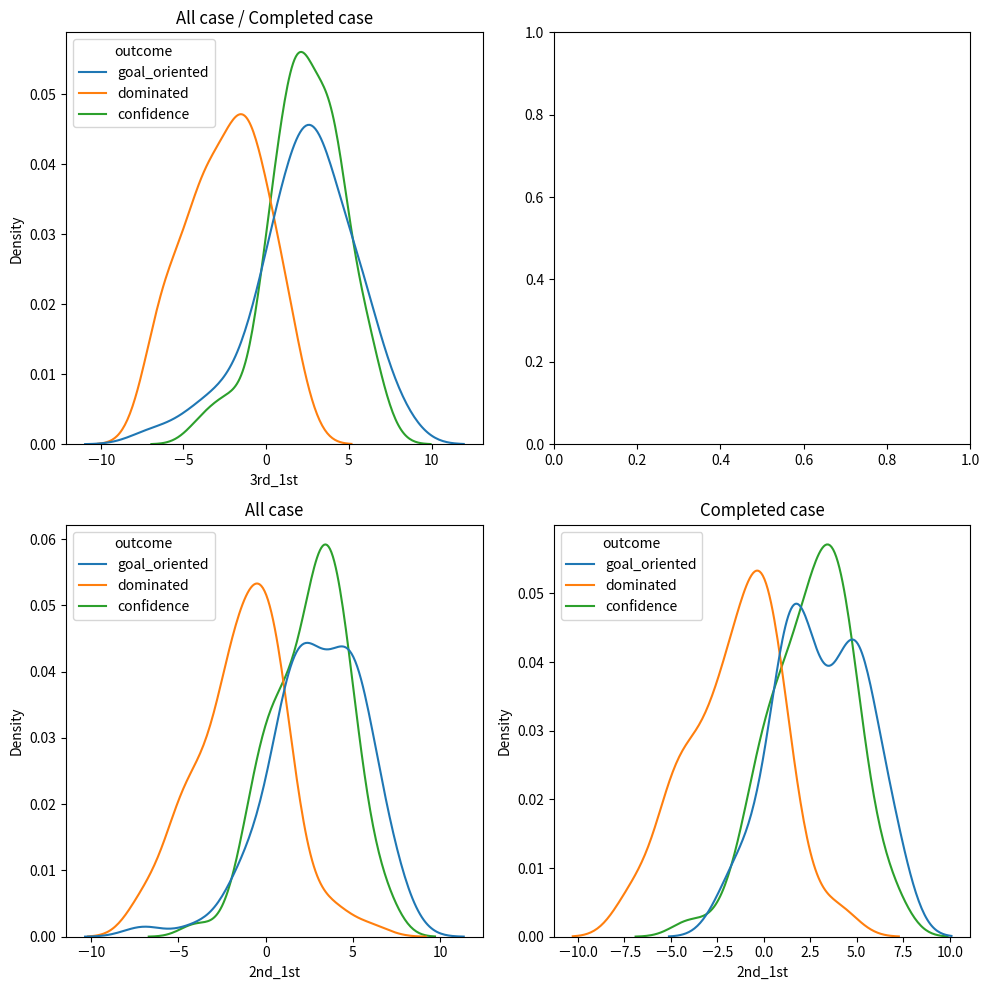

In [52]:
fig, ax = plt.subplots(2,2, figsize=[10,10])
sns.kdeplot(x='3rd_1st',data=sst_data_r_wide,hue='outcome',ax=ax[0,0]).set(title='All case / Completed case');
sns.kdeplot(x='2nd_1st',data=sst_data_r_wide,hue='outcome',ax=ax[1,0]).set(title='All case');
sns.kdeplot(x='2nd_1st',data=sst_data_r_completed_wide,hue='outcome',ax=ax[1,1]).set(title='Completed case');
plt.tight_layout();